# **Building a LSTM univariate model**

## **Starting point: predict next day's close price**
Before we start building the model, we should take a look on how closing prices look like.

In [1]:
!pip install tensorflow --quiet
!pip install yfinance   --quiet

import math as mt
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow import keras
from seaborn import set_style
from sklearn.preprocessing import MinMaxScaler

set_style("darkgrid")

# For reproducibility
np.random.seed(24)
tf.random.set_seed(24)

In [2]:
start_date_AAPL = "1980-12-12"   # Apple's first day on the stock market
end_date_AAPL   = "2023-06-24"

start_date_AMZN = "1990-05-15"   # Amazon's first day on the stock market
end_date_AMZN   = "2023-06-24"

apple_ticker  = "AAPL"
amazon_ticker = "AMZN"

AAPL = yf.download(apple_ticker, start=start_date_AAPL, end=end_date_AAPL)
AMZN = yf.download(amazon_ticker, start=start_date_AMZN, end=end_date_AMZN)

# Convert index to datetime
AAPL.index = pd.to_datetime(AAPL.index)
AMZN.index = pd.to_datetime(AMZN.index)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


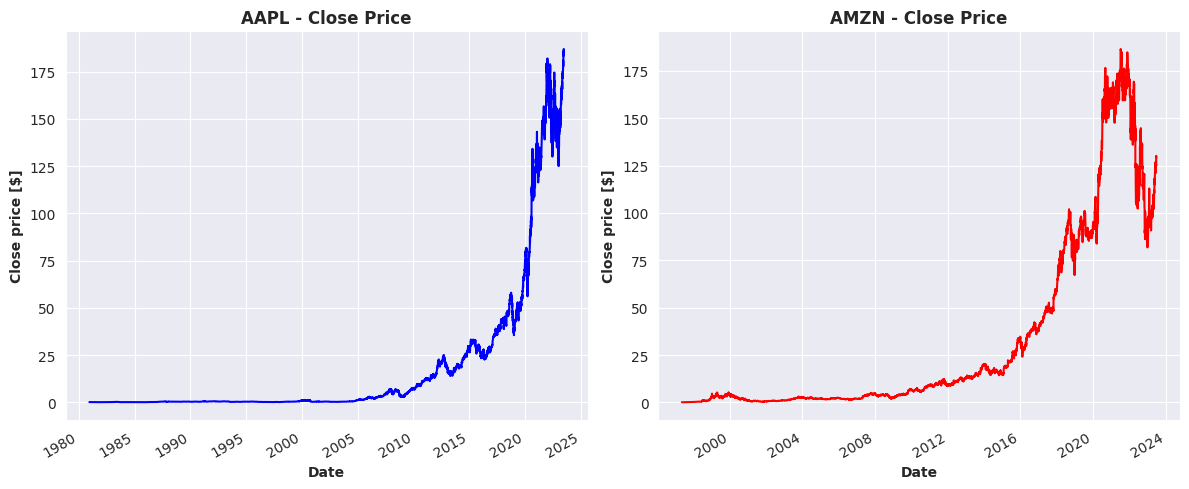

In [3]:
# Plotting close prices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title('AAPL - Close Price', fontweight='bold')
AAPL.loc[AAPL.index, 'Close'].plot(ax=axes[0], label='Close price', color='blue')
axes[0].set_xlabel('Date', fontweight='bold')
axes[0].set_ylabel('Close price [$]', fontweight='bold')

axes[1].set_title('AMZN - Close Price', fontweight='bold')
AMZN.loc[AMZN.index, 'Close'].plot(ax=axes[1], label='Close price', color='red')
axes[1].set_xlabel('Date', fontweight='bold')
axes[1].set_ylabel('Close price [$]', fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Since the datasets span a long period, we should consider reducing them to a more recent and relevant subset. This can help capture the most recent patterns and trends, which are likely to be more valuable for our purposes.

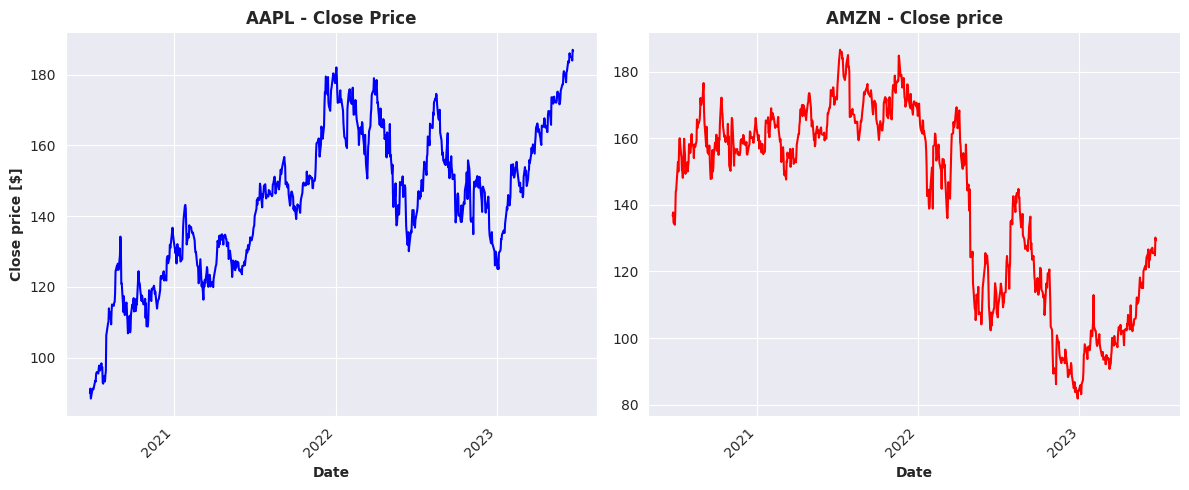

In [4]:
start_date = pd.to_datetime('2020-06-24')
end_date = pd.to_datetime('2023-06-24')

AAPL_reduced = AAPL[(AAPL.index >= start_date) & (AAPL.index <= end_date)]
AMZN_reduced = AMZN[(AMZN.index >= start_date) & (AMZN.index <= end_date)]

AAPL_reduced = AAPL_reduced.drop(['Open','High','Low','Adj Close','Volume'], axis=1)
AMZN_reduced = AMZN_reduced.drop(['Open','High','Low','Adj Close','Volume'], axis=1)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot AAPL Close Price
axes[0].plot(AAPL_reduced.index, AAPL.loc[AAPL_reduced.index, 'Close'], color='blue')
axes[0].set_title('AAPL - Close Price', fontweight='bold')
axes[0].set_xlabel('Date', fontweight='bold')
axes[0].set_ylabel('Close price [$]', fontweight='bold')
axes[0].grid(True)

# Format x-axis as dates (AAPL)
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate(rotation=45)  # Rotate x-axis labels for better readability

# Plot Amazon Trend
axes[1].plot(AMZN_reduced.index, AMZN.loc[AMZN_reduced.index, 'Close'], color="red")
axes[1].set_title('AMZN - Close price', fontweight='bold')
axes[1].set_xlabel('Date', fontweight='bold')
axes[1].grid(True)

# Format x-axis as dates (AMZN)
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

AAPL_scaler = MinMaxScaler()
AMZN_scaler = MinMaxScaler()

# Reshape the data to have a shape of (-1, 1)
AAPL_close_prices = AAPL_reduced['Close'].values.reshape(-1, 1)
AMZN_close_prices = AMZN_reduced['Close'].values.reshape(-1, 1)

# Fit the scaler
AAPL_scaler.fit(AAPL_close_prices)
AMZN_scaler.fit(AMZN_close_prices)

# Apply min-max scaling
AAPL_scaled = AAPL_scaler.transform(AAPL_close_prices)
AMZN_scaled = AMZN_scaler.transform(AMZN_close_prices)

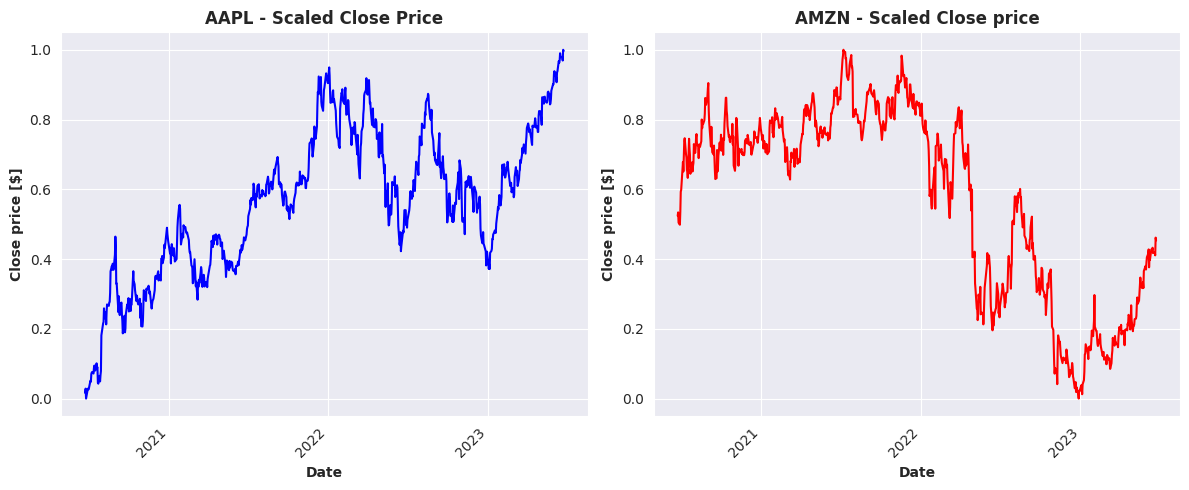

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot AAPL scaled close prices
axes[0].plot(AAPL_reduced.index, AAPL_scaled, color='blue')
axes[0].set_title('AAPL - Scaled Close Price', fontweight='bold')
axes[0].set_xlabel('Date', fontweight='bold')
axes[0].set_ylabel('Close price [$]', fontweight='bold')
axes[0].grid(True)

# Format x-axis as dates (AAPL)
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate(rotation=45)

# Plot Amazon scaled close prices
axes[1].plot(AMZN_reduced.index, AMZN_scaled, color="red")
axes[1].set_title('AMZN - Scaled Close price', fontweight='bold')
axes[1].set_xlabel('Date', fontweight='bold')
axes[1].set_ylabel('Close price [$]', fontweight='bold')
axes[1].grid(True)

# Format x-axis as dates (AMZN)
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate(rotation=45)

plt.tight_layout()
plt.show()

## **Creating train, validation and test dataset**

In [7]:
def create_dataset(dataset, lookback):
    X_train = []
    Y_train = []

    for i in range(lookback, len(dataset)):
        X_train.append(dataset[i-lookback:i])
        Y_train.append(dataset[i])

    return np.array(X_train), np.array(Y_train)

In [8]:
# Split the data into training, validation, and testing sets
AAPL_train_size = int(len(AAPL_scaled) * 0.7)
AAPL_val_size   = int(len(AAPL_scaled) * 0.2)
AAPL_train_data = AAPL_scaled[:AAPL_train_size]
AAPL_val_data   = AAPL_scaled[AAPL_train_size:AAPL_train_size + AAPL_val_size]
AAPL_test_data  = AAPL_scaled[AAPL_train_size + AAPL_val_size:]

AMZN_train_size = int(len(AMZN_scaled) * 0.7)
AMZN_val_size   = int(len(AMZN_scaled) * 0.2)
AMZN_train_data = AMZN_scaled[:AMZN_train_size]
AMZN_val_data   = AMZN_scaled[AMZN_train_size:AMZN_train_size + AMZN_val_size]
AMZN_test_data  = AMZN_scaled[AMZN_train_size + AMZN_val_size:]

In [9]:
AAPL_X_train, AAPL_Y_train = create_dataset(AAPL_train_data, lookback=7)
AMZN_X_train, AMZN_Y_train = create_dataset(AMZN_train_data, lookback=7)

AAPL_X_val, AAPL_Y_val = create_dataset(AAPL_val_data, lookback=7)
AMZN_X_val, AMZN_Y_val = create_dataset(AMZN_val_data, lookback=7)

AAPL_X_test, AAPL_Y_test = create_dataset(AAPL_test_data, lookback=7)
AMZN_X_test, AMZN_Y_test = create_dataset(AMZN_test_data, lookback=7)

## **Close price prediction - Building the LSTM** (**1st attempt**)

To build the LSTM, we need to import a couple of modules from `Keras`:

- `Sequential` for initializing the neural network.
- `Dense` for adding a densely connected neural network layer.
- `LSTM` for adding the Long Short-Term Memory layer.
- `Dropout` for adding dropout layers that prevent overfitting.

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
lookback = 7

#################### AAPL ####################
AAPL_regressor = Sequential()

AAPL_regressor.add(LSTM(units=8,
                   input_shape=(lookback, 1)))

AAPL_regressor.add(Dense(units=1))
##############################################

#################### AMZN ####################
AMZN_regressor = Sequential()

AMZN_regressor.add(LSTM(units=8,
                   input_shape=(lookback, 1)))

AMZN_regressor.add(Dense(units=1))
##############################################

## **Training and evaluating the model**

To monitor the error made by the model we will use **Symmetric Mean Absolute Percentage Error** (SMAPE). SMAPE addresses the lack of symmetry in MAPE (Mean Absolute Percentage Error) by taking the average of the absolute percentage differences between the predicted and actual values, considering both positive and negative errors. We decide to use SMAPE instead of MAPE because SMAPE treats overestimations and underestimations equally.

In [12]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).

    Args:
        actual (Tensor): TensorFlow tensor of actual values.
        predicted (Tensor): TensorFlow tensor of predicted values.

    Returns:
        Tensor: SMAPE value.
    """
    numerator = tf.abs(actual - predicted)
    denominator = (tf.abs(actual) + tf.abs(predicted)) / 2.0

    smape_score = tf.reduce_mean(numerator / denominator) * 100.0

    return smape_score


def compile_and_fit(model, X_train, Y_train, X_val, Y_val, file='',
                    _patience=10, _min_delta=0.0001, _epochs=100, _batch_size=32, _early_stopping=False,
                    _learning_rate=0.01, _verbose=1, _save_model=False):

    callbacks = []


    if _early_stopping:
        early_stopping = EarlyStopping(monitor='val_smape',
                                       patience=_patience,
                                       min_delta=_min_delta,
                                       mode='min')
        callbacks.append(early_stopping)


    if _save_model:
        # Define a ModelCheckpoint callback to save the best model to Google Drive
        checkpoint_path = '/content/drive/MyDrive/_Casu_Deiana/Models/' + str(file) + '.h5'
        checkpoint = ModelCheckpoint(checkpoint_path,
                                     monitor='val_smape',
                                     save_best_only=True,
                                     mode='min',
                                     verbose=1)
        callbacks.append(checkpoint)


    _optimizer = Adam(learning_rate=_learning_rate)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=_optimizer,
                  metrics=[smape])


    if _verbose != 0:
        model.summary()
        plot_model(model, show_shapes=True, show_layer_names=True)


    history = model.fit(X_train, Y_train,
                        batch_size=_batch_size,
                        epochs=_epochs,
                        validation_data=(X_val, Y_val),
                        callbacks=callbacks,
                        verbose=_verbose)

    return history

Mounted at /content/drive


### **AAPL - Close price training**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 4s 36ms/step - loss: 0.0341 - smape: 34.2123 - val_loss: 0.0048 - val_smape: 9.8022
Epoch 2/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0039 - smape: 11.9788 - val_loss: 0.0022 - val_smape: 6.6617
Epoch 3/100
33/33 [==============================] - 0s 10ms/step - loss: 0.0018 - smape: 7.8680 - val_loss: 0.0022 - val_smape: 6.5347
Epoch 4/100
33/33 [=========================

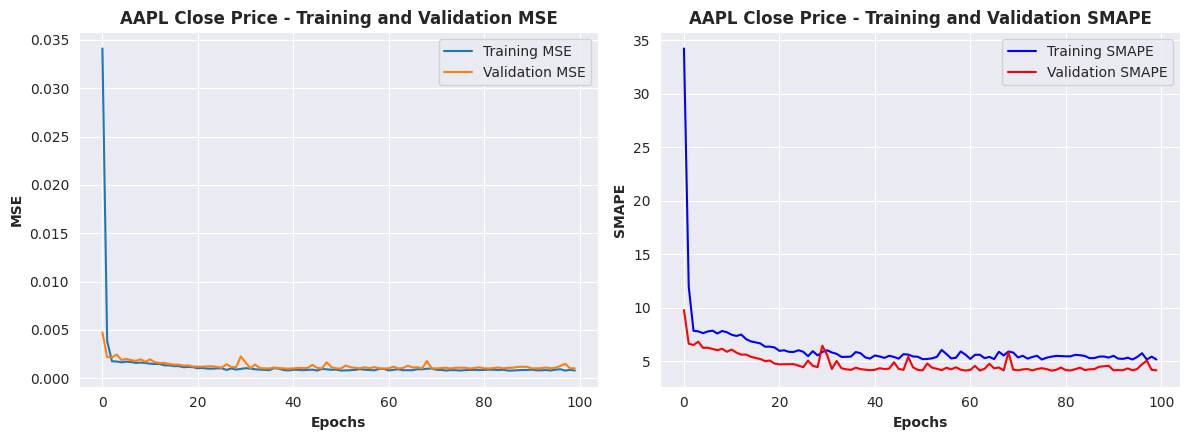

In [13]:
history = compile_and_fit(AAPL_regressor, X_train=AAPL_X_train, Y_train=AAPL_Y_train, X_val=AAPL_X_val, Y_val=AAPL_Y_val, _batch_size=16)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AAPL Close Price - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AAPL Close Price - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [14]:
AAPL_predictions = AAPL_regressor.predict(AAPL_X_test)

# Evaluate the model on the test dataset
loss = AAPL_regressor.evaluate(AAPL_X_test, AAPL_Y_test, batch_size=32)

3/3 [==============================] - 1s 6ms/step - loss: 4.8243e-04 - smape: 1.9129


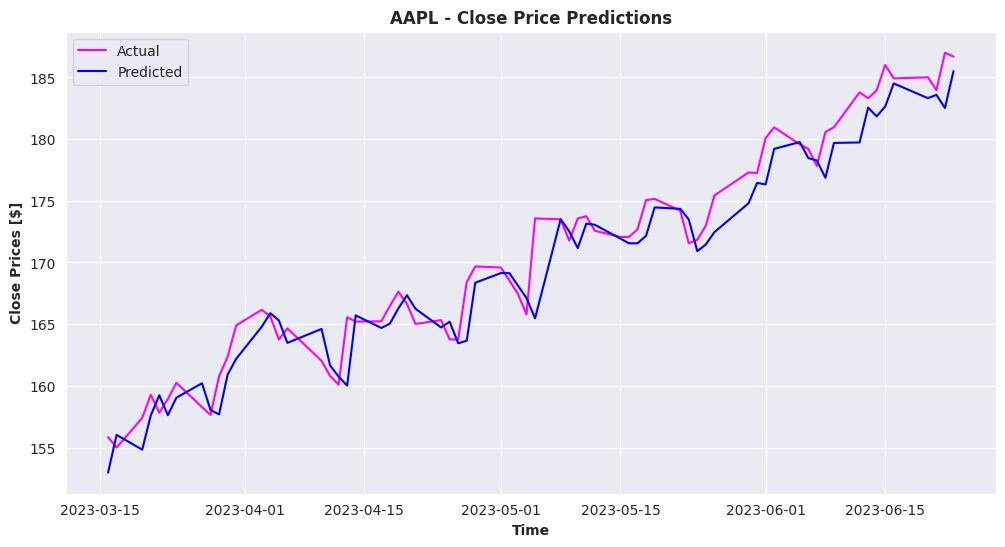

In [15]:
# Plotting AAPL close price predictions
plt.figure(figsize=(12, 6))
plt.plot(AAPL.index[-len(AAPL_Y_test):].values, AAPL_scaler.inverse_transform(AAPL_Y_test), label='Actual', color='magenta')
plt.plot(AAPL.index[-len(AAPL_Y_test):].values, AAPL_scaler.inverse_transform(AAPL_predictions), label='Predicted', color='blue')
plt.title('AAPL - Close Price Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Close Prices [$]', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - Close price training**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 3s 32ms/step - loss: 0.0833 - smape: 38.0669 - val_loss: 0.0477 - val_smape: 78.8040
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0092 - smape: 11.9802 - val_loss: 0.0243 - val_smape: 65.8488
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0040 - smape: 8.1154 - val_loss: 0.0061 - val_smape: 39.5669
Epoch 4/100
33/33 [======================

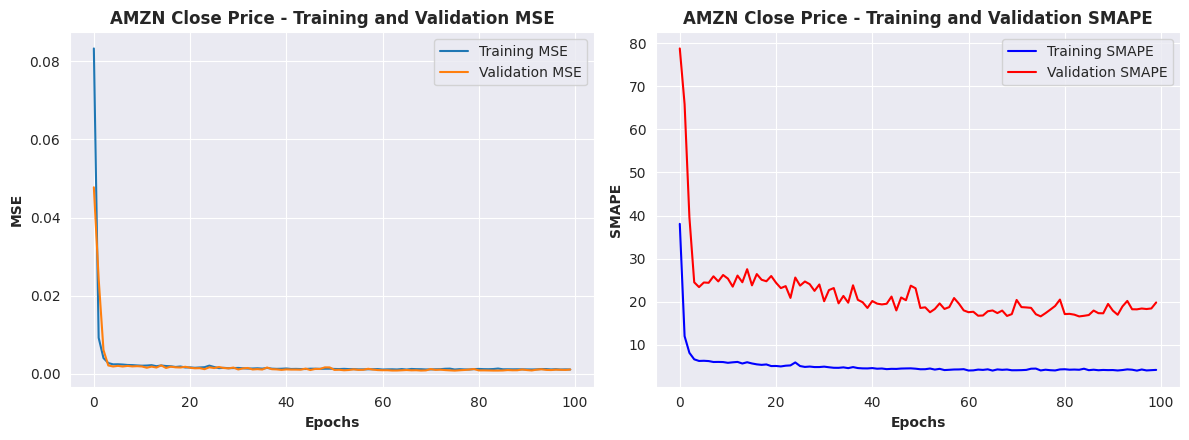

In [16]:
history = compile_and_fit(AMZN_regressor, X_train=AMZN_X_train, Y_train=AMZN_Y_train, X_val=AMZN_X_val, Y_val=AMZN_Y_val, _batch_size=16)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AMZN Close Price - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AMZN Close Price - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
AMZN_predictions = AMZN_regressor.predict(AMZN_X_test)

# Evaluate the model on the test dataset
loss = AMZN_regressor.evaluate(AMZN_X_test, AMZN_Y_test, batch_size=32)

3/3 [==============================] - 1s 7ms/step - loss: 4.6000e-04 - smape: 6.3832


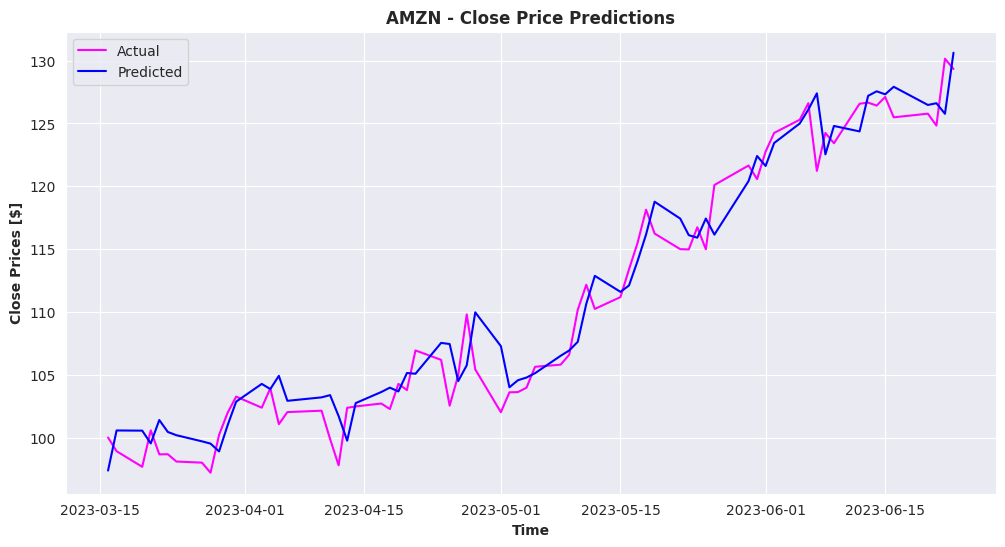

In [18]:
# Plotting AMZN close price predictions
plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_Y_test):].values, AMZN_scaler.inverse_transform(AMZN_Y_test), label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_Y_test):].values, AMZN_scaler.inverse_transform(AMZN_predictions), label='Predicted', color='blue')
plt.title('AMZN - Close Price Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Close Prices [$]', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

## **Too easy?**
Stock prices are not necessarily "easy" to predict with LSTM or any other predictive model. Predicting stock prices accurately is a complex and challenging task due to various factors, including market dynamics, economic indicators, news events and investor sentiment, among others.

However, RNN networks (LSTM for us) are a popular choice for modeling sequential data, such as stock prices, due to their ability to capture temporal dependencies and patterns in the data.

There are a few reasons why LSTMs may show promise in predicting stock prices:
- **Capturing temporal dependencies**. LSTMs excel at capturing dependencies over time, which can be crucial in stock price prediction.
- **Handling nonlinear relationships**. Stock price movements are (often) nonlinear and influenced by a multitude of factors. LSTMs can learn complex nonlinear relationships and potentially capture hidden patterns that linear models may struggle to capture.

Despite these advantages, predicting stock prices accurately is still a challenging task due to the inherent volatility and unpredictability of financial markets.

## **Why are prices misleading?**
Understanding the trend of a stock is often considered more important than accurately predicting the prices of the next day. Here are a few reasons why:
- **Long-term Perspective**. Stock investing is typically focused on the long-term. Investors aim to identify stocks that have the potential for sustained growth over an extended period. Understanding the overall trend helps investors make informed decisions about whether to buy, hold, or sell a stock based on its long-term prospects.
- **Risk Management**. By focusing on the trend, investors can better manage risk. Short-term price fluctuations are influenced by various factors and can be volatile and unpredictable. Relying solely on short-term price predictions can expose investors to unnecessary risks. Understanding the broader trend provides a more comprehensive view of the stock's performance and helps investors assess risk levels.
- **Avoiding Noise and Speculation**. Short-term price movements can be influenced by market noise, rumors, or short-term market sentiment. Focusing on the trend helps investors filter out such noise and avoid getting swayed by short-term fluctuations driven by speculation or market sentiment.

Trying to predict the next close price given the previous T close prices *would not be useful*. Let's see an example:

* Suppose that our model has a very high accurancy.  
* Also, suppose that the model's predicted direction is **always wrong**.
* E.g. yesterday's price is \$1000 and today's price is \$1000.01. Our model, given yesterday's price as input, predicts \$999.99 (error = \$0.02).
* If I made the decision, based on the predicted price, to sell the stock, I would always lose money!

Based on the considerations made above, we decided to focus our analysis to **returns**.

# **Returns**
While stock prices still hold significance, *returns* provide a more meaningful and comprehensive perspective on investment performance. Returns are the difference between the price of an asset at two different times. Mathematically, we can express the return for a period of time $T$ as:

**RETURN($t$)** = **Price($t$) - Price($t$ - $T$ )**

A big advantage of using returns is that they are **stationary**. Infact, when a time-series is not stationary, a *differencing* operation is often applied to it. In other words, we take the difference between two "adjacent" samples.

### **The problem**
Suppose that we bought a stock on day $t$. Now the problem we are addressing is the following: given a sequence of returns of the last $S$ trading days, we would like to predict the return on investment for day $t+T$ ($t+T = S+1$). This means that, for each trading day, we calculate the returns as if the stock were bought $T$ days ago. With the returns of the last $S$ trading days, we aim to predict the return on investment if we were to sell the stock tomorrow.

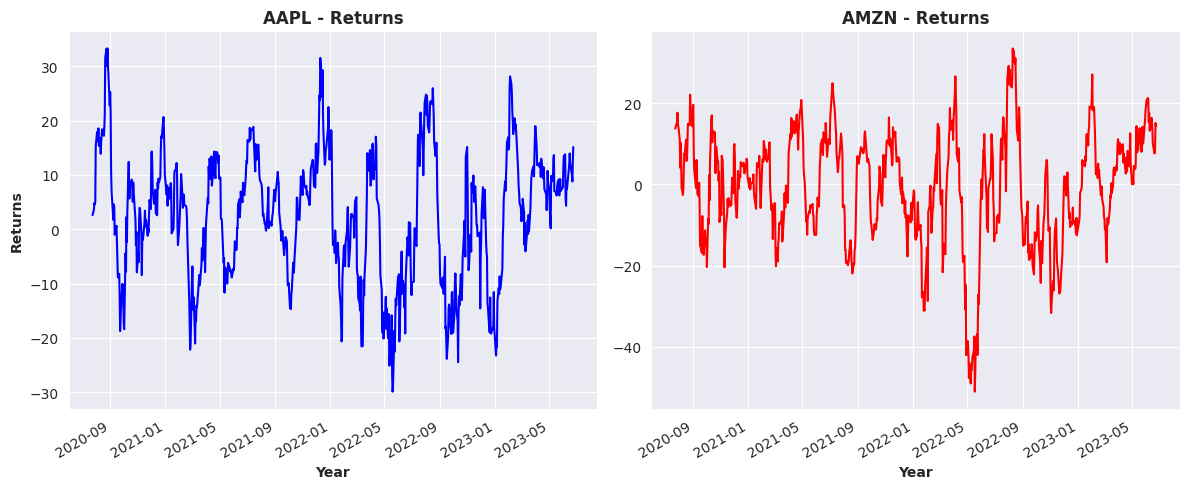

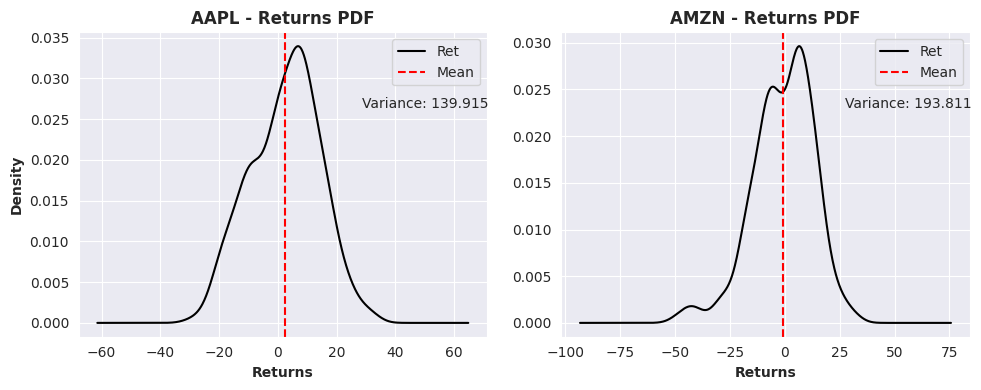

In [19]:
from scipy import stats

T = 21

start_date = pd.to_datetime('2020-06-24')
end_date = pd.to_datetime('2023-06-24')

AAPL_reduced = AAPL[(AAPL.index >= start_date) & (AAPL.index <= end_date)]
AMZN_reduced = AMZN[(AMZN.index >= start_date) & (AMZN.index <= end_date)]

AAPL_reduced = AAPL_reduced.drop(['Open','High','Low','Adj Close','Volume'], axis=1)
AMZN_reduced = AMZN_reduced.drop(['Open','High','Low','Adj Close','Volume'], axis=1)

AAPL_returns = AAPL_reduced['Close'] - AAPL_reduced['Close'].shift(T)
AMZN_returns = AMZN_reduced['Close'] - AMZN_reduced['Close'].shift(T)

AAPL_reduced['Ret'] = AAPL_returns
AMZN_reduced['Ret'] = AMZN_returns

AAPL_reduced = AAPL_reduced.iloc[T:]
AMZN_reduced = AMZN_reduced.iloc[T:]

################################################################################

fig, _axes = plt.subplots(1, 2, figsize=(12, 5))

_axes[0].set_title('AAPL - Returns', fontweight='bold')
AAPL_reduced['Ret'].plot(ax=_axes[0], color='blue')
_axes[0].set_xlabel('Year', fontweight='bold')
_axes[0].set_ylabel('Returns', fontweight='bold')

_axes[1].set_title('AMZN - Returns', fontweight='bold')
AMZN_reduced['Ret'].plot(ax=_axes[1], color='red')
_axes[1].set_xlabel('Year', fontweight='bold')

plt.tight_layout()
plt.show()

################################################################################

AAPL_mean     = AAPL_reduced['Ret'].mean()
AAPL_variance = AAPL_reduced['Ret'].var()
AAPL_std      = AAPL_reduced['Ret'].std()
AMZN_mean     = AMZN_reduced['Ret'].mean()
AMZN_variance = AMZN_reduced['Ret'].var()
AMZN_std      = AMZN_reduced['Ret'].std()


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot PDF of AAPL returns
axes[0].set_title('AAPL - Returns PDF', fontweight='bold')
AAPL_reduced['Ret'].plot.kde(ax=axes[0], color='black')
axes[0].set_xlabel('Returns', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
axes[0].axvline(AAPL_mean, color='red', linestyle='--', label='Mean')
axes[0].text(0.85, 0.75, f'Variance: {AAPL_variance:.3f}', transform=axes[0].transAxes, ha='center')
axes[0].legend()

# Plot PDF of AMZN returns
axes[1].set_title('AMZN - Returns PDF', fontweight='bold')
AMZN_reduced['Ret'].plot.kde(ax=axes[1], color='black')
axes[1].set_xlabel('Returns', fontweight='bold')
axes[1].set_ylabel('')
axes[1].axvline(AMZN_mean, color='red', linestyle='--', label='Mean')
axes[1].text(0.85, 0.75, f'Variance: {AMZN_variance:.3f}', transform=axes[1].transAxes, ha='center')
axes[1].legend()

plt.tight_layout()
plt.show()

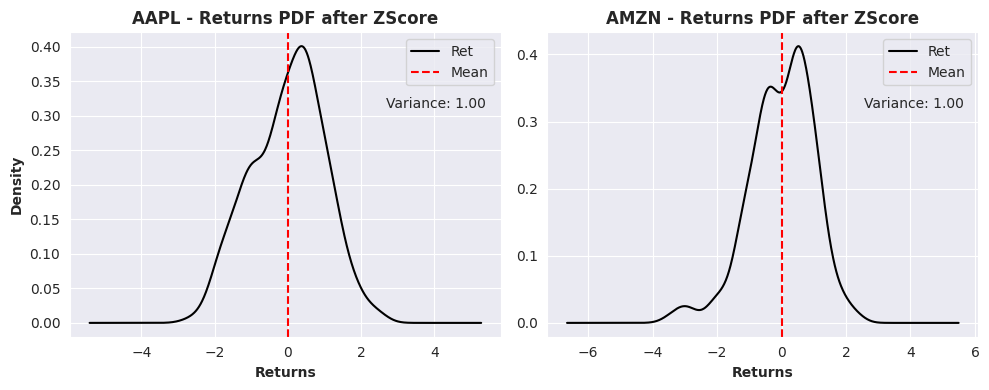

In [20]:
# Zscore normalization
AAPL_scaled = stats.zscore(AAPL_reduced['Ret'])
AMZN_scaled = stats.zscore(AMZN_reduced['Ret'])

AAPL_mean_scaled     = AAPL_scaled.mean()
AAPL_variance_scaled = AAPL_scaled.var()
AMZN_mean_scaled     = AMZN_scaled.mean()
AMZN_variance_scaled = AMZN_scaled.var()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot PDF of AAPL scaled returns
axes[0].set_title('AAPL - Returns PDF after ZScore', fontweight='bold')
AAPL_scaled.plot.kde(ax=axes[0], color='black')
axes[0].set_xlabel('Returns', fontweight='bold')
axes[0].set_ylabel('Density', fontweight='bold')
axes[0].axvline(AAPL_mean_scaled, color='red', linestyle='--', label='Mean')
axes[0].text(0.85, 0.75, f'Variance: {AAPL_variance_scaled:.2f}', transform=axes[0].transAxes, ha='center')
axes[0].legend()

# Plot PDF of AMZN scaled returns
axes[1].set_title('AMZN - Returns PDF after ZScore', fontweight='bold')
AMZN_scaled.plot.kde(ax=axes[1], color='black')
axes[1].set_xlabel('Returns', fontweight='bold')
axes[1].set_ylabel('')
axes[1].axvline(AMZN_mean_scaled, color='red', linestyle='--', label='Mean')
axes[1].text(0.85, 0.75, f'Variance: {AMZN_variance_scaled:.2f}', transform=axes[1].transAxes, ha='center')
axes[1].legend()

plt.tight_layout()
plt.show()

## **Building a LSTM model to predict Returns**

First of all, let's take a look on how the data look like:

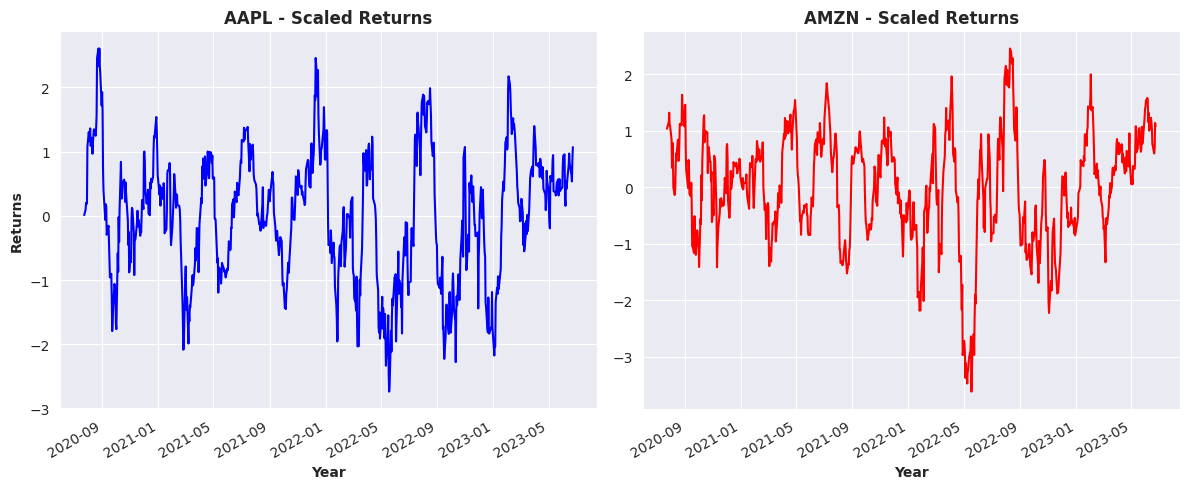

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title('AAPL - Scaled Returns', fontweight='bold')
AAPL_scaled.plot(ax=axes[0], color='blue')
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Returns', fontweight='bold')

axes[1].set_title('AMZN - Scaled Returns', fontweight='bold')
AMZN_scaled.plot(ax=axes[1], color='red')
axes[1].set_xlabel('Year', fontweight='bold')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [22]:
# Split the data into training, validation, and testing sets
AAPL_RET_train_size = int(len(AAPL_scaled) * 0.7)
AAPL_RET_val_size   = int(len(AAPL_scaled) * 0.2)
AAPL_RET_train_data = AAPL_scaled[:AAPL_RET_train_size]
AAPL_RET_val_data   = AAPL_scaled[AAPL_RET_train_size:AAPL_RET_train_size + AAPL_RET_val_size]
AAPL_RET_test_data  = AAPL_scaled[AAPL_RET_train_size + AAPL_RET_val_size:]

AMZN_RET_train_size = int(len(AAPL_scaled) * 0.7)
AMZN_RET_val_size   = int(len(AAPL_scaled) * 0.2)
AMZN_RET_train_data = AMZN_scaled[:AMZN_RET_train_size]
AMZN_RET_val_data   = AMZN_scaled[AMZN_RET_train_size:AMZN_RET_train_size + AMZN_RET_val_size]
AMZN_RET_test_data  = AMZN_scaled[AMZN_RET_train_size + AMZN_RET_val_size:]

In [23]:
AAPL_RET_X_train, AAPL_RET_Y_train = create_dataset(AAPL_RET_train_data, lookback=7)
AMZN_RET_X_train, AMZN_RET_Y_train = create_dataset(AMZN_RET_train_data, lookback=7)

AAPL_RET_X_val, AAPL_RET_Y_val = create_dataset(AAPL_RET_val_data, lookback=7)
AMZN_RET_X_val, AMZN_RET_Y_val = create_dataset(AMZN_RET_val_data, lookback=7)

AAPL_RET_X_test, AAPL_RET_Y_test = create_dataset(AAPL_RET_test_data, lookback=7)
AMZN_RET_X_test, AMZN_RET_Y_test = create_dataset(AMZN_RET_test_data, lookback=7)

In [24]:
#################### AAPL ####################
AAPL_RET_regressor = Sequential()

AAPL_RET_regressor.add(LSTM(units=8,
                   input_shape=(7, 1)))

AAPL_RET_regressor.add(Dense(units=1))
##############################################

#################### AMZN ####################
AMZN_RET_regressor = Sequential()

AMZN_RET_regressor.add(LSTM(units=8,
                   input_shape=(7, 1)))

AMZN_RET_regressor.add(Dense(units=1))
##############################################

## **Training and evaluating the model - (AAPL - 1st attempt)**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 4s 71ms/step - loss: 0.8729 - smape: 143.4273 - val_loss: 0.6980 - val_smape: 116.2930
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.3623 - smape: 82.0677 - val_loss: 0.4207 - val_smape: 92.7935
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.2643 - smape: 73.8082 - val_loss: 0.2893 - val_smape: 81.5224
Epoch 4/100
16/16 [=================

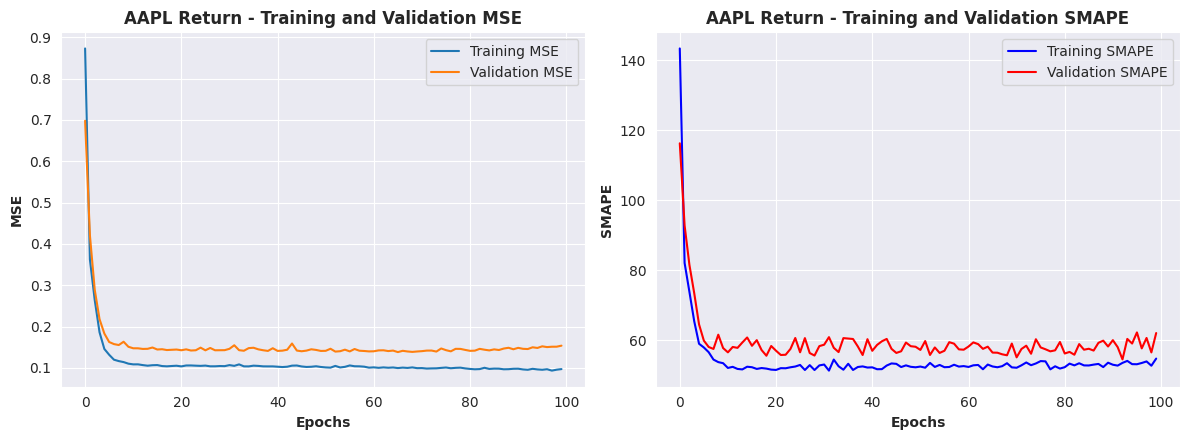

In [25]:
history = compile_and_fit(AAPL_RET_regressor, AAPL_RET_X_train, AAPL_RET_Y_train, AAPL_RET_X_val, AAPL_RET_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AAPL Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AAPL Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [26]:
AAPL_RET_predictions = AAPL_RET_regressor.predict(AAPL_RET_X_test)
loss = AAPL_RET_regressor.evaluate(AAPL_RET_X_test, AAPL_RET_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0587 - smape: 38.2556


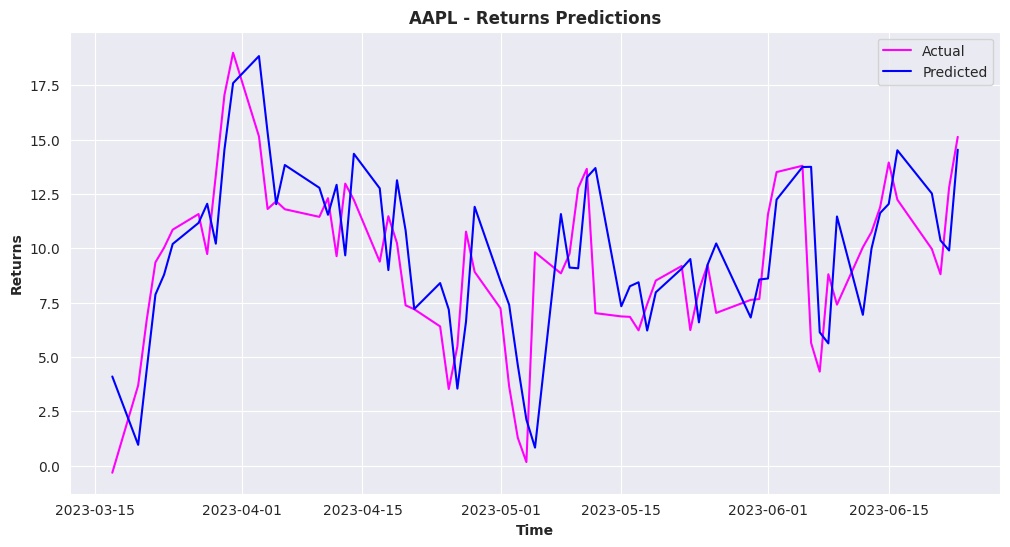

In [27]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_Y_test * AAPL_std) + AAPL_mean
AAPL_predictions = (AAPL_RET_predictions * AAPL_std) + AAPL_mean

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

## **Training and evaluating the model** (**AMZN** - **1st attempt**)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 44ms/step - loss: 0.6758 - smape: 128.2974 - val_loss: 0.3181 - val_smape: 88.4184
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.3584 - smape: 82.7891 - val_loss: 0.2279 - val_smape: 78.7681
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2442 - smape: 73.0582 - val_loss: 0.1535 - val_smape: 67.2043
Epoch 4/100
16/16 [====================

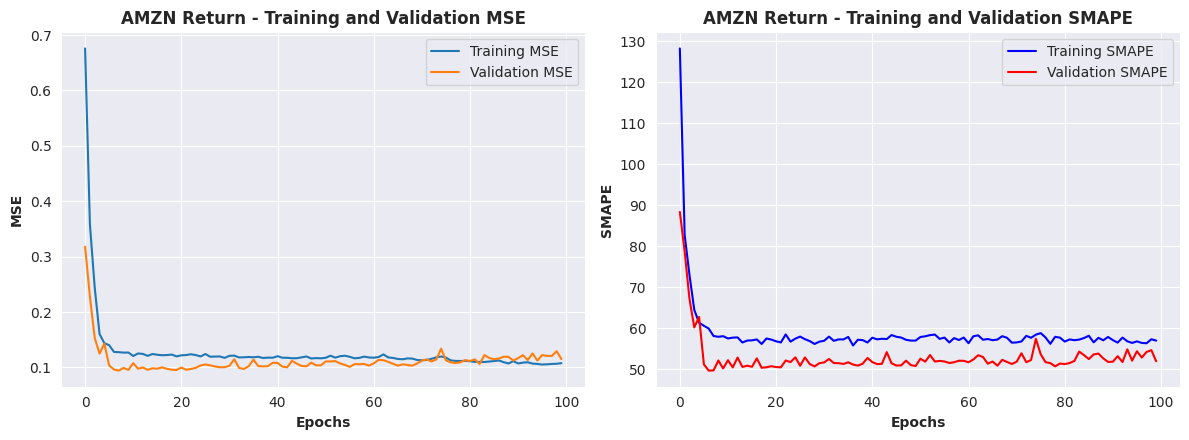

In [28]:
history = compile_and_fit(AMZN_RET_regressor, AMZN_RET_X_train, AMZN_RET_Y_train, AMZN_RET_X_val, AMZN_RET_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AMZN Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AMZN Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [29]:
AMZN_RET_predictions = AMZN_RET_regressor.predict(AMZN_RET_X_test)
loss = AMZN_RET_regressor.evaluate(AMZN_RET_X_test, AMZN_RET_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0598 - smape: 39.5702


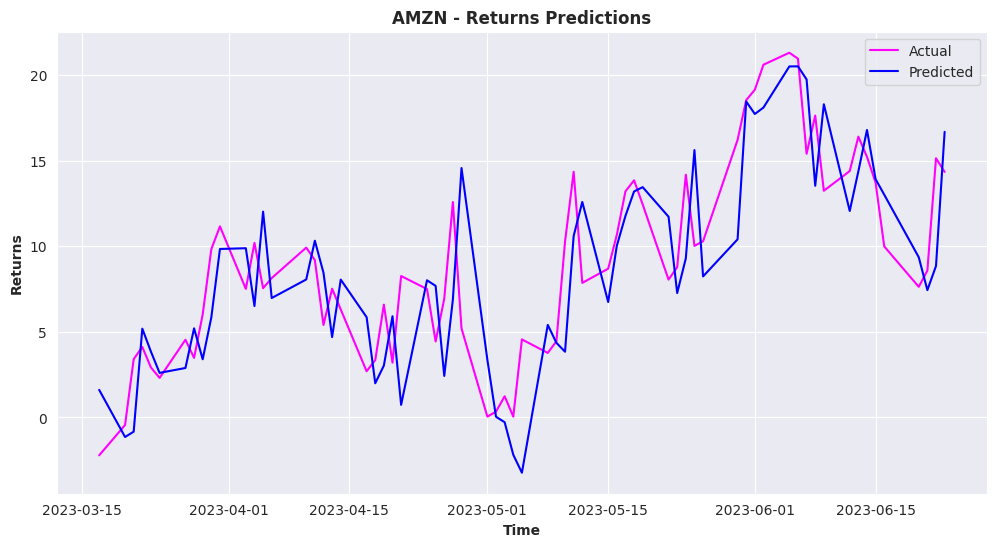

In [30]:
# Inverse transform AMZN Returns
AMZN_test = (AMZN_RET_Y_test * AMZN_std) + AMZN_mean
AMZN_predictions = (AMZN_RET_predictions * AMZN_std) + AMZN_mean

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

In order to help the model to learn better, we decided to apply a moving average whose `window_size` = $S$. Specifically, the moving average should help smooth out fluctuations in return's time series.

## **Training and evaluating the model** (**Moving Average**)

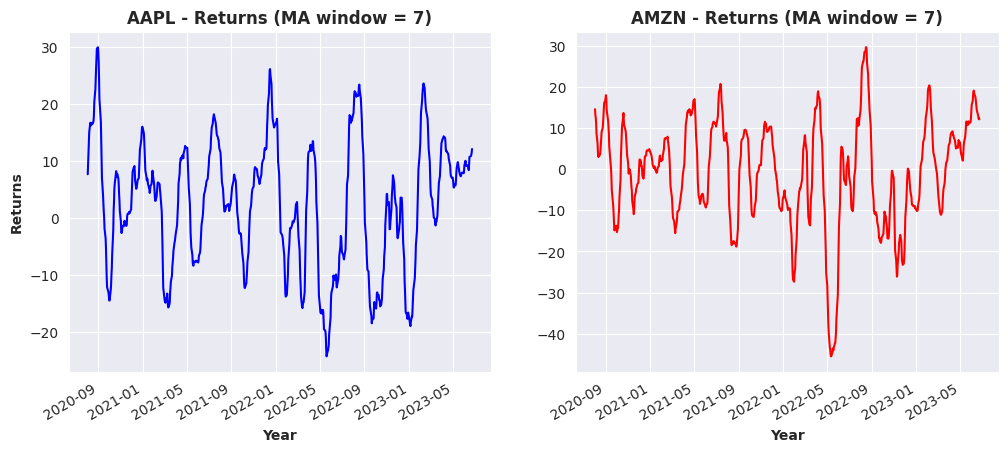

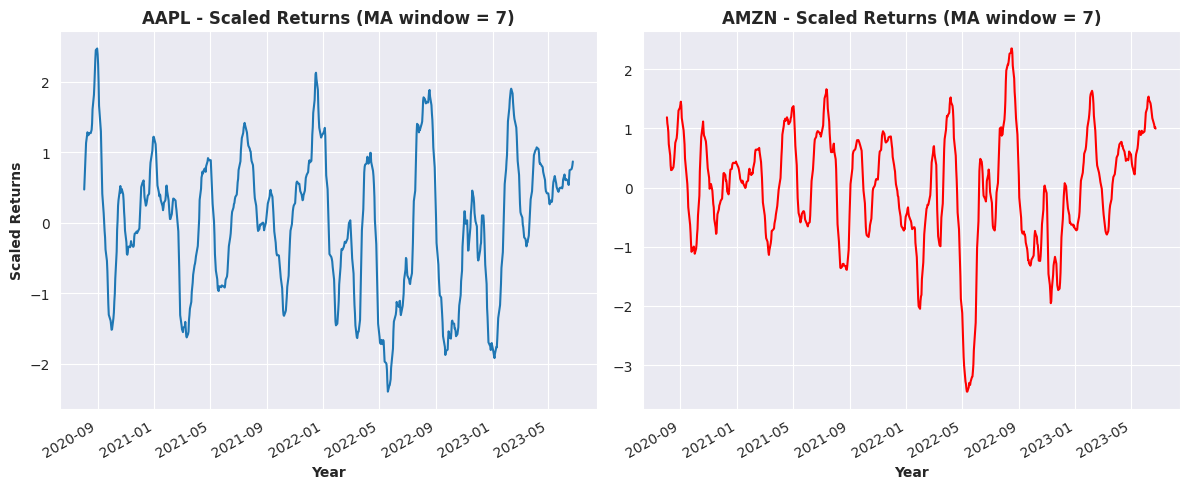

In [31]:
window_size = 7
AAPL_RET_MA = AAPL_reduced['Ret'].rolling(window=window_size).mean()
AMZN_RET_MA = AMZN_reduced['Ret'].rolling(window=window_size).mean()

# Drop missing values from the moving average series
AAPL_RET_MA = AAPL_RET_MA.dropna()
AMZN_RET_MA = AMZN_RET_MA.dropna()

AAPL_mean_MA     = AAPL_RET_MA.mean()
AAPL_variance_MA = AAPL_RET_MA.var()
AAPL_std_MA      = AAPL_RET_MA.std()
AMZN_mean_MA     = AMZN_RET_MA.mean()
AMZN_variance_MA = AMZN_RET_MA.var()
AMZN_std_MA      = AMZN_RET_MA.std()

fig, _axes = plt.subplots(1, 2, figsize=(12, 5))

_axes[0].set_title('AAPL - Returns (MA window = ' + str(window_size) + ')', fontweight='bold')
AAPL_RET_MA.plot(ax=_axes[0], color='blue')
_axes[0].set_xlabel('Year', fontweight='bold')
_axes[0].set_ylabel('Returns', fontweight='bold')

_axes[1].set_title('AMZN - Returns (MA window = ' + str(window_size) + ')', fontweight='bold')
AMZN_RET_MA.plot(ax=_axes[1], color='red')
_axes[1].set_xlabel('Year', fontweight='bold')

################################################################################

# Zscore normalization
AAPL_RET_MA_scaled = stats.zscore(AAPL_RET_MA)
AMZN_RET_MA_scaled = stats.zscore(AMZN_RET_MA)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title('AAPL - Scaled Returns (MA window = ' + str(window_size) + ')', fontweight='bold')
AAPL_RET_MA_scaled.plot(ax=axes[0])
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Scaled Returns', fontweight='bold')

axes[1].set_title('AMZN - Scaled Returns (MA window = ' + str(window_size) + ')', fontweight='bold')
AMZN_RET_MA_scaled.plot(ax=axes[1], color='red')
axes[1].set_xlabel('Year', fontweight='bold')

plt.tight_layout()
plt.show()

## **Creating train, validation and test dataset**

In [32]:
# Split the data into training, validation, and testing sets
AAPL_RET_MA_train_size = int(len(AAPL_RET_MA_scaled) * 0.7)
AAPL_RET_MA_val_size   = int(len(AAPL_RET_MA_scaled) * 0.2)
AAPL_RET_MA_train_data = AAPL_RET_MA_scaled[:AAPL_RET_MA_train_size]
AAPL_RET_MA_val_data   = AAPL_RET_MA_scaled[AAPL_RET_MA_train_size:AAPL_RET_MA_train_size + AAPL_RET_MA_val_size]
AAPL_RET_MA_test_data  = AAPL_RET_MA_scaled[AAPL_RET_MA_train_size + AAPL_RET_MA_val_size:]

AMZN_RET_MA_train_size = int(len(AMZN_RET_MA_scaled) * 0.7)
AMZN_RET_MA_val_size   = int(len(AMZN_RET_MA_scaled) * 0.2)
AMZN_RET_MA_train_data = AMZN_RET_MA_scaled[:AMZN_RET_MA_train_size]
AMZN_RET_MA_val_data   = AMZN_RET_MA_scaled[AMZN_RET_MA_train_size:AMZN_RET_MA_train_size + AMZN_RET_MA_val_size]
AMZN_RET_MA_test_data  = AMZN_RET_MA_scaled[AMZN_RET_MA_train_size + AMZN_RET_MA_val_size:]

In [33]:
AAPL_RET_MA_X_train, AAPL_RET_MA_Y_train = create_dataset(AAPL_RET_MA_train_data, lookback=7)
AMZN_RET_MA_X_train, AMZN_RET_MA_Y_train = create_dataset(AMZN_RET_MA_train_data, lookback=7)

AAPL_RET_MA_X_val, AAPL_RET_MA_Y_val = create_dataset(AAPL_RET_MA_val_data, lookback=7)
AMZN_RET_MA_X_val, AMZN_RET_MA_Y_val = create_dataset(AMZN_RET_MA_val_data, lookback=7)

AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test = create_dataset(AAPL_RET_MA_test_data, lookback=7)
AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test = create_dataset(AMZN_RET_MA_test_data, lookback=7)

In [34]:
############### AAPL - RET_MA ############
AAPL_RET_MA_regressor = Sequential()

AAPL_RET_MA_regressor.add(LSTM(units=8,
                   input_shape=(7, 1)))

AAPL_RET_MA_regressor.add(Dense(units=1))
##########################################

############### AMZN - RET_MA ############
AMZN_RET_MA_regressor = Sequential()

AMZN_RET_MA_regressor.add(LSTM(units=8,
                   input_shape=(7, 1)))

AMZN_RET_MA_regressor.add(Dense(units=1))
##########################################

### **AAPL**

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 62ms/step - loss: 0.8578 - smape: 140.4128 - val_loss: 0.5835 - val_smape: 106.3636
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.2710 - smape: 72.5891 - val_loss: 0.2828 - val_smape: 81.9399
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1559 - smape: 59.6938 - val_loss: 0.1615 - val_smape: 71.2072
Epoch 4/100
16/16 [=================

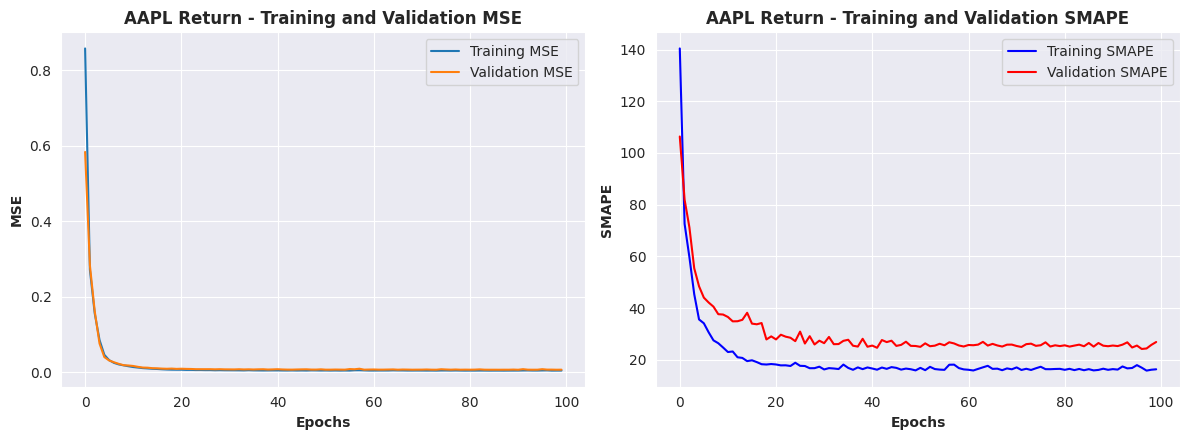

In [35]:
history = compile_and_fit(AAPL_RET_MA_regressor, X_train=AAPL_RET_MA_X_train, Y_train=AAPL_RET_MA_Y_train, X_val=AAPL_RET_MA_X_val, Y_val=AAPL_RET_MA_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AAPL Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AAPL Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [36]:
AAPL_RET_MA_predictions = AAPL_RET_MA_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_8, AAPL_smape_8 = AAPL_RET_MA_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0027 - smape: 8.3605


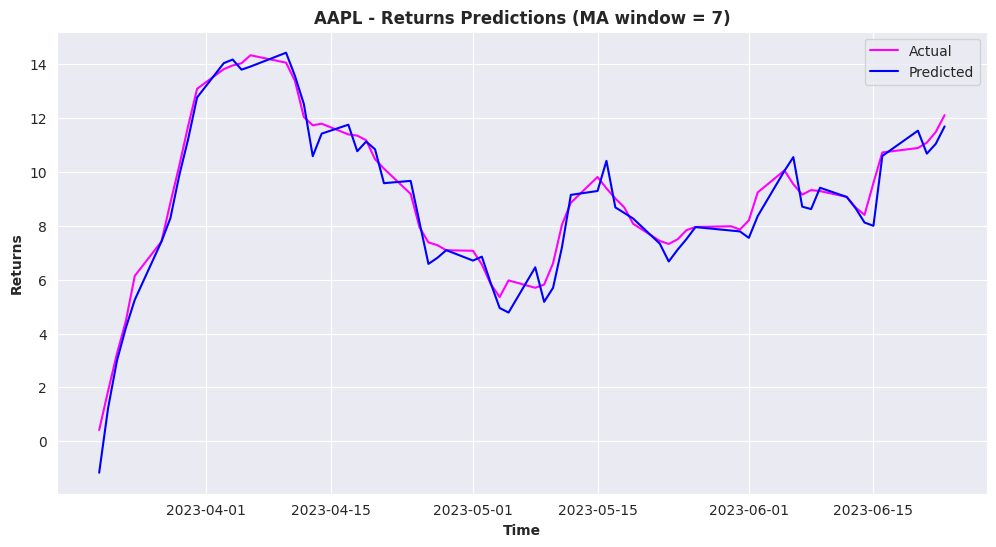

In [37]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_MA_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ')', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN**

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 8)                 320       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 45ms/step - loss: 1.0640 - smape: 153.2441 - val_loss: 0.3839 - val_smape: 98.4999
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.4035 - smape: 84.7817 - val_loss: 0.1916 - val_smape: 72.7433
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2288 - smape: 69.8342 - val_loss: 0.1110 - val_smape: 64.7029
Epoch 4/100
16/16 [====================

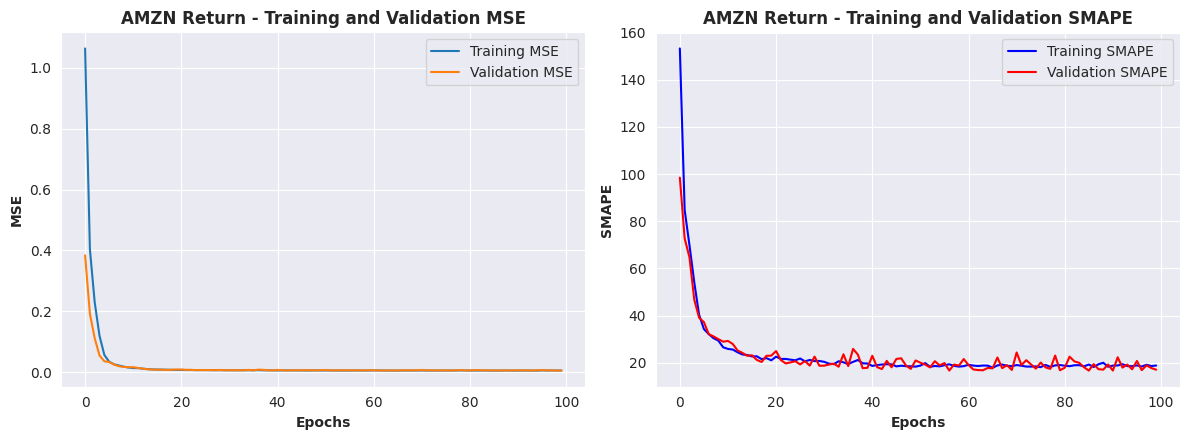

In [38]:
history = compile_and_fit(AMZN_RET_MA_regressor, X_train=AMZN_RET_MA_X_train, Y_train=AMZN_RET_MA_Y_train, X_val=AMZN_RET_MA_X_val, Y_val=AMZN_RET_MA_Y_val)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training MSE')
ax1.plot(history.history['val_loss'], label='Validation MSE')
ax1.set_title('AMZN Return - Training and Validation MSE', fontweight='bold')
ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold')
ax1.legend()

# Plot training loss and validation smape
ax2.plot(history.history['smape'], label='Training SMAPE', color='blue')
ax2.plot(history.history['val_smape'], label='Validation SMAPE', color='red')
ax2.set_title('AMZN Return - Training and Validation SMAPE', fontweight='bold')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('SMAPE', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [39]:
AMZN_RET_MA_predictions = AMZN_RET_MA_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_8, AMZN_smape_8 = AMZN_RET_MA_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 8ms/step - loss: 0.0031 - smape: 8.4921


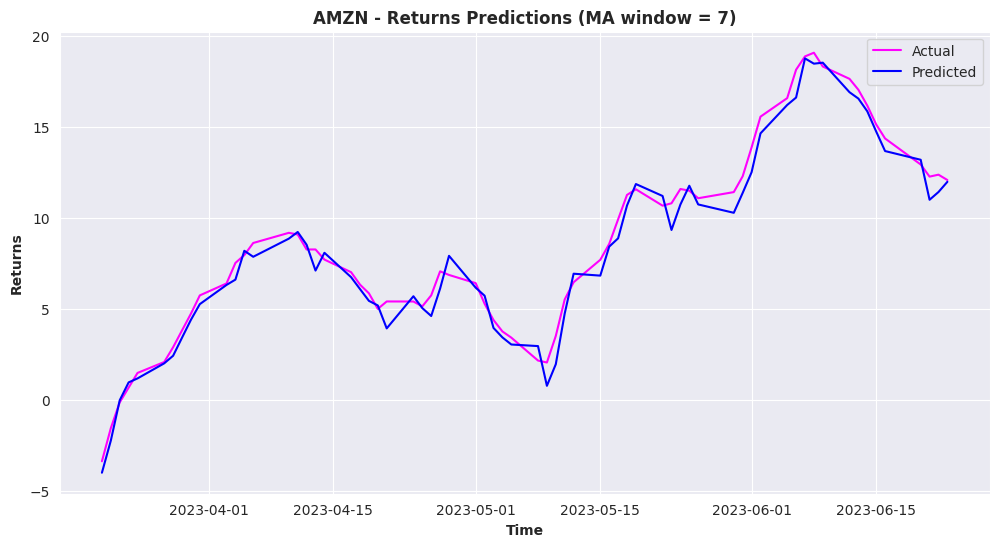

In [40]:
# Inverse transform AAPL Returns
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_MA_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ')', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# **Improving perfomance**

## **Increasing the number of units**
Increasing the number of neurons can help the model capture more complex patterns in the data, but can also increase the risk of overfitting.

### **AAPL - 16 units**

In [41]:
batch_size = 32

############### AAPL - RET_MA ###############
AAPL_RET_16_regressor = Sequential()

AAPL_RET_16_regressor.add(LSTM(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_16_regressor.add(Dense(units=1))
##########################################

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (32, 16)                  1152      
                                                                 
 dense_6 (Dense)             (32, 1)                   17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 45ms/step - loss: 0.4311 - smape: 98.9137 - val_loss: 0.2502 - val_smape: 79.9022
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.1512 - smape: 61.5313 - val_loss: 0.1435 - val_smape: 72.6562
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0705 - smape: 47.1355 - val_loss: 0.0487 - val_smape: 52.0346
Epoch 4/100
16/16 [=================

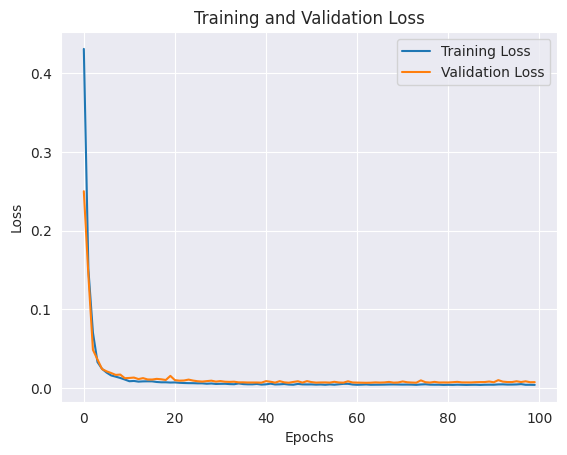

In [42]:
history = compile_and_fit(AAPL_RET_16_regressor, X_train=AAPL_RET_MA_X_train, Y_train=AAPL_RET_MA_Y_train, X_val=AAPL_RET_MA_X_val, Y_val=AAPL_RET_MA_Y_val)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
AAPL_RET_16_predictions = AAPL_RET_16_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_16, AAPL_smape_16  = AAPL_RET_16_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0030 - smape: 8.9492


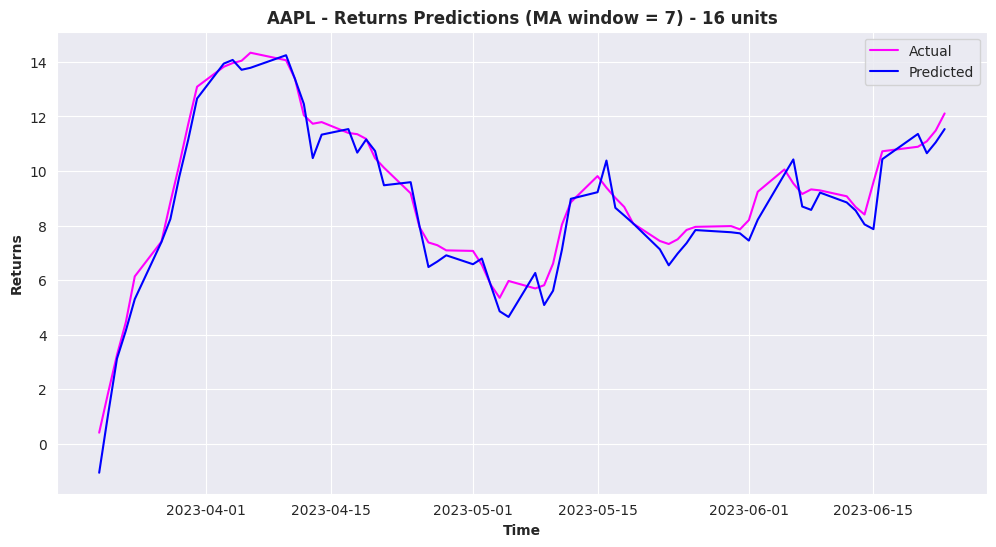

In [44]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_16_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 16 units**

In [45]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_16_regressor = Sequential()

AMZN_RET_16_regressor.add(LSTM(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_16_regressor.add(Dense(units=1))
##########################################

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (32, 16)                  1152      
                                                                 
 dense_7 (Dense)             (32, 1)                   17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 4s 71ms/step - loss: 0.5795 - smape: 114.8841 - val_loss: 0.2557 - val_smape: 80.8184
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.1800 - smape: 68.0796 - val_loss: 0.0983 - val_smape: 61.7960
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0693 - smape: 49.0688 - val_loss: 0.0443 - val_smape: 40.1372
Epoch 4/100
16/16 [==============

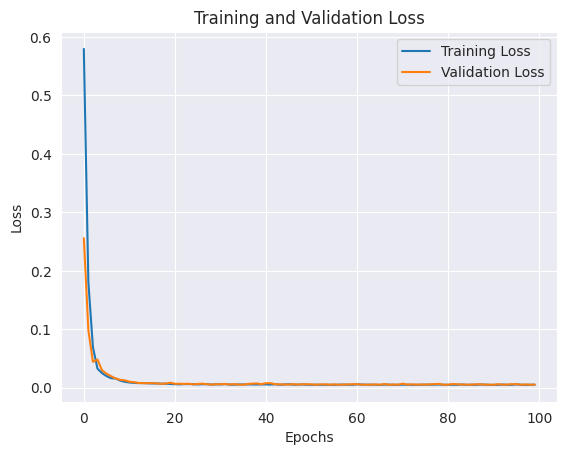

In [46]:
history = compile_and_fit(AMZN_RET_16_regressor, X_train=AMZN_RET_MA_X_train, Y_train=AMZN_RET_MA_Y_train, X_val=AMZN_RET_MA_X_val, Y_val=AMZN_RET_MA_Y_val)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
AMZN_RET_16_predictions = AMZN_RET_16_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_16, AMZN_smape_16  = AMZN_RET_16_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0028 - smape: 8.0496


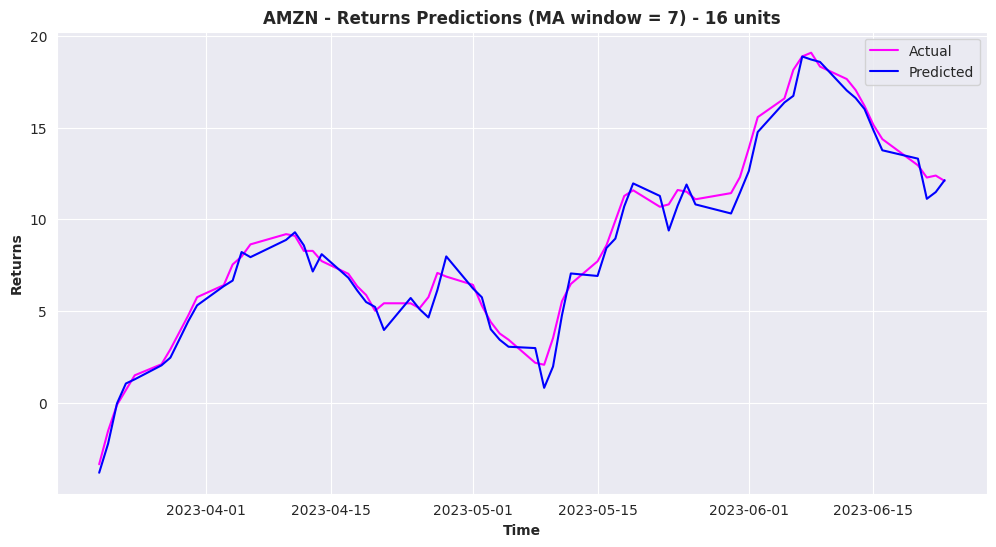

In [48]:
# Inverse transform AMZN Returns
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_16_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 32 units**

In [49]:
batch_size = 32

############### AAPL - LOGRET_MA ###############
AAPL_RET_32_regressor = Sequential()

AAPL_RET_32_regressor.add(LSTM(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_32_regressor.add(Dense(units=1))
##########################################

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (32, 32)                  4352      
                                                                 
 dense_8 (Dense)             (32, 1)                   33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 46ms/step - loss: 0.3410 - smape: 89.4688 - val_loss: 0.2181 - val_smape: 75.2093
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.1094 - smape: 52.6371 - val_loss: 0.1046 - val_smape: 64.1908
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0440 - smape: 38.2304 - val_loss: 0.0379 - val_smape: 48.6856
Epoch 4/100
16/16 [=================

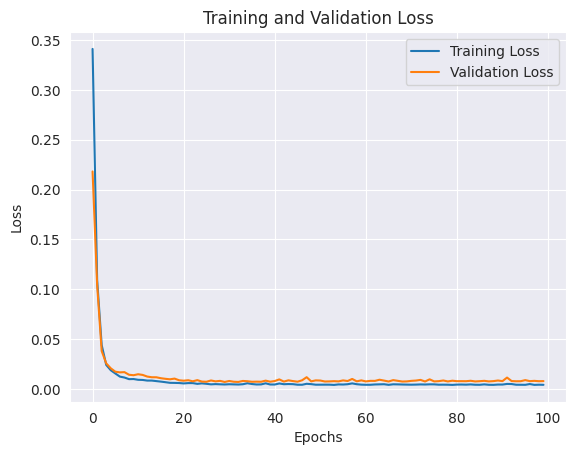

In [50]:
history = compile_and_fit(AAPL_RET_32_regressor, AAPL_RET_MA_X_train, AAPL_RET_MA_Y_train, AAPL_RET_MA_X_val, AAPL_RET_MA_Y_val)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
AAPL_RET_32_predictions = AAPL_RET_32_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_32, AAPL_smape_32  = AAPL_RET_32_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0033 - smape: 9.6956


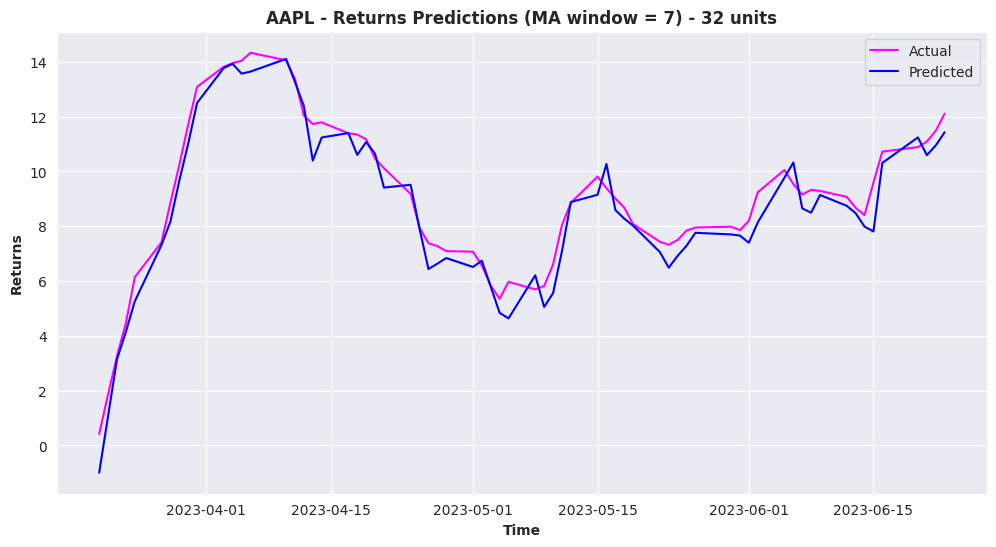

In [52]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_32_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 32 units**

In [53]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_32_regressor = Sequential()

AMZN_RET_32_regressor.add(LSTM(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_32_regressor.add(Dense(units=1))
##########################################

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (32, 32)                  4352      
                                                                 
 dense_9 (Dense)             (32, 1)                   33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 3s 45ms/step - loss: 0.2537 - smape: 79.3688 - val_loss: 0.1046 - val_smape: 70.4789
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0736 - smape: 49.3632 - val_loss: 0.0492 - val_smape: 39.7758
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0357 - smape: 38.1383 - val_loss: 0.0421 - val_smape: 36.7966
Epoch 4/100
16/16 [=================

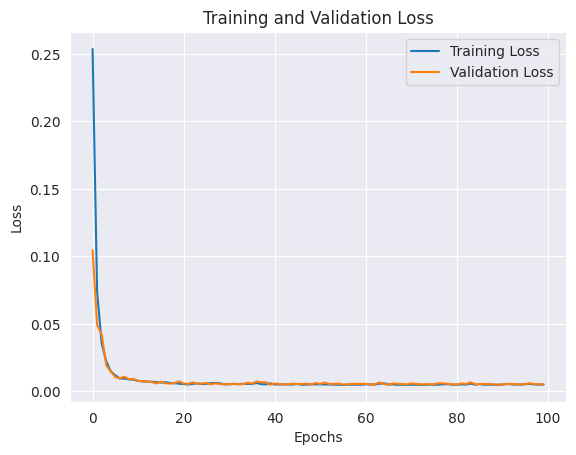

In [54]:
history = compile_and_fit(AMZN_RET_32_regressor, X_train=AMZN_RET_MA_X_train, Y_train=AMZN_RET_MA_Y_train, X_val=AMZN_RET_MA_X_val, Y_val=AMZN_RET_MA_Y_val)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
AMZN_RET_32_predictions = AMZN_RET_32_regressor.predict(AMZN_RET_MA_X_test)

# Evaluate the model on the test dataset
AMZN_loss_32, AMZN_smape_32  = AMZN_RET_32_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0025 - smape: 7.8156


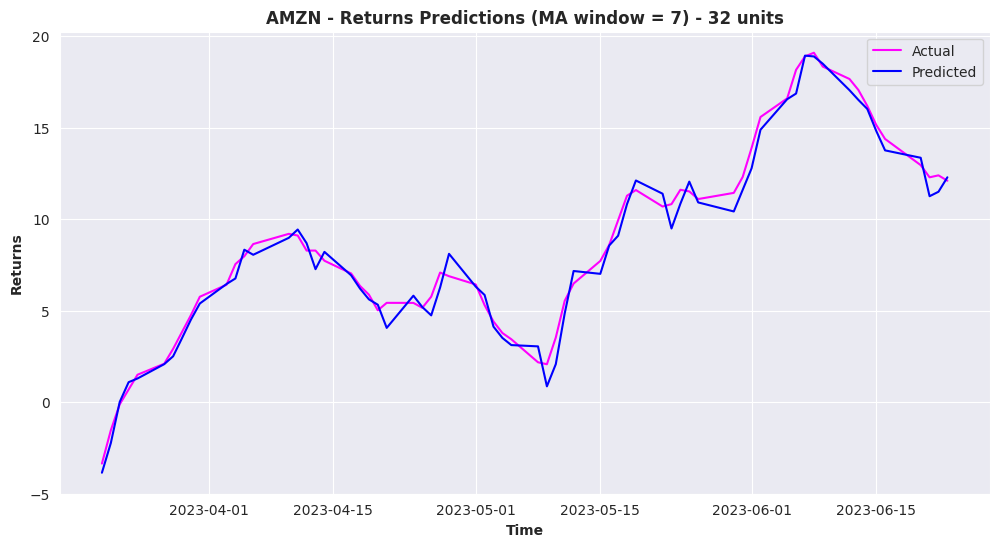

In [56]:
# Inverse transform AMZN Returns
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_32_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

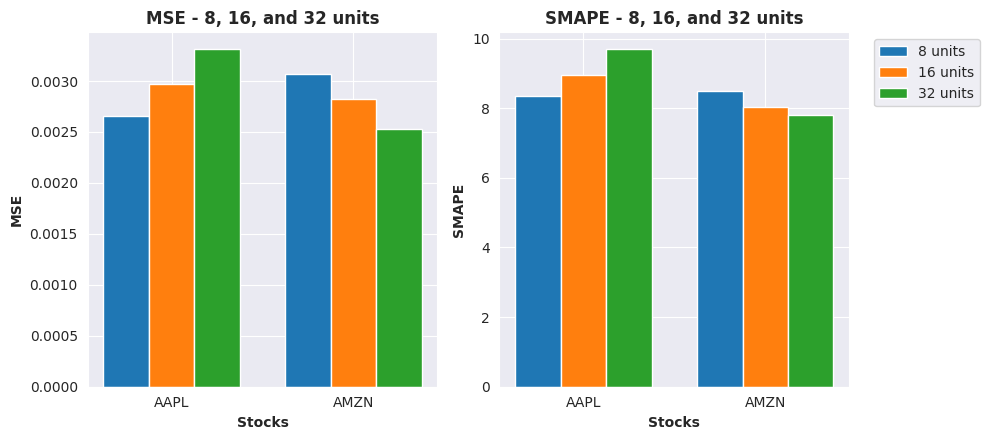

In [57]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_8, AAPL_loss_16, AAPL_loss_32],    [AMZN_loss_8, AMZN_loss_16, AMZN_loss_32]])
smape_values  = np.array([[AAPL_smape_8, AAPL_smape_16, AAPL_smape_32],[AMZN_smape_8, AMZN_smape_16, AMZN_smape_32 ]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.25, align='center', label='8 units')
axs[0].bar(x + 0.25, loss_values[:, 1], width=0.25, align='center', label='16 units')
axs[0].bar(x + 0.5, loss_values[:, 2], width=0.25, align='center', label='32 units')
axs[0].set_xticks(x + 0.25, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE - 8, 16, and 32 units', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.25, align='center', label='8 units')
axs[1].bar(x + 0.25, smape_values[:, 1], width=0.25, align='center', label='16 units')
axs[1].bar(x + 0.5, smape_values[:, 2], width=0.25, align='center', label='32 units')
axs[1].set_xticks(x + 0.25, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE - 8, 16, and 32 units', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## **Tuning training hyperparameters**


### **AAPL - 8 units, `epochs`=250, `batch_size`=16**



In [58]:
batch_size = 16

############### AAPL - RET_MA ###############
AAPL_RET_8_ES_regressor = Sequential()

AAPL_RET_8_ES_regressor.add(LSTM(units=8,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_8_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (16, 8)                   320       
                                                                 
 dense_10 (Dense)            (16, 1)                   9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 5s 70ms/step - loss: 0.3041 - smape: 76.1305 - val_loss: 0.1798 - val_smape: 75.3798
Epoch 2/250
32/32 [==============================] - 0s 6ms/step - loss: 0.0846 - smape: 45.7805 - val_loss: 0.0450 - val_smape: 46.1720
Epoch 3/250
32/32 [==============================] - 0s 8ms/step - loss: 0.0250 - smape: 30.7903 - val_loss: 0.0245 - val_smape: 37.7811
Epoch 4/250
32/32 [====================

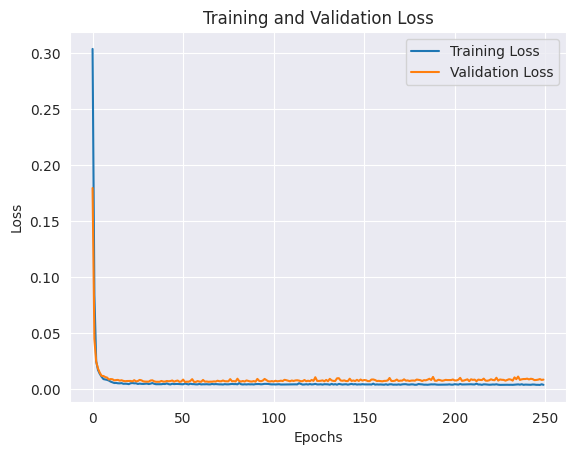

In [59]:
history = compile_and_fit(AAPL_RET_8_ES_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [60]:
AAPL_RET_8_ES_predictions = AAPL_RET_8_ES_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_8_ES, AAPL_smape_8_ES = AAPL_RET_8_ES_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0026 - smape: 8.3747


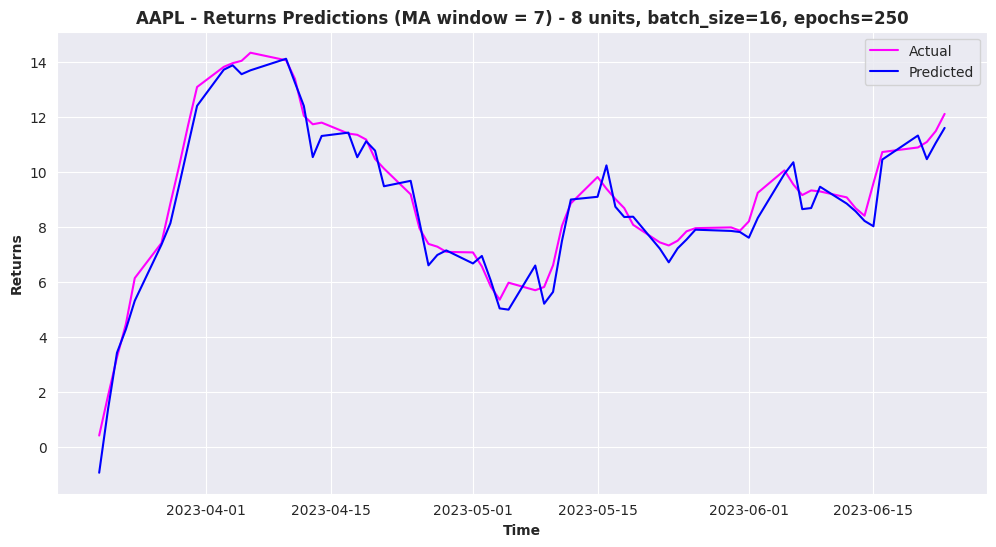

In [61]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_8_ES_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 8 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 8 units, `epochs`=250, `batch_size`=16**


In [62]:
batch_size = 16

############### AMZN - RET_MA ###############
AMZN_RET_8_ES_regressor = Sequential()

AMZN_RET_8_ES_regressor.add(LSTM(units=8,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_8_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (16, 8)                   320       
                                                                 
 dense_11 (Dense)            (16, 1)                   9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 3s 24ms/step - loss: 0.4841 - smape: 96.7255 - val_loss: 0.1216 - val_smape: 61.4258
Epoch 2/250
32/32 [==============================] - 0s 6ms/step - loss: 0.1129 - smape: 49.2581 - val_loss: 0.0608 - val_smape: 40.1890
Epoch 3/250
32/32 [==============================] - 0s 7ms/step - loss: 0.0390 - smape: 37.1521 - val_loss: 0.0265 - val_smape: 32.9173
Epoch 4/250
32/32 [====================

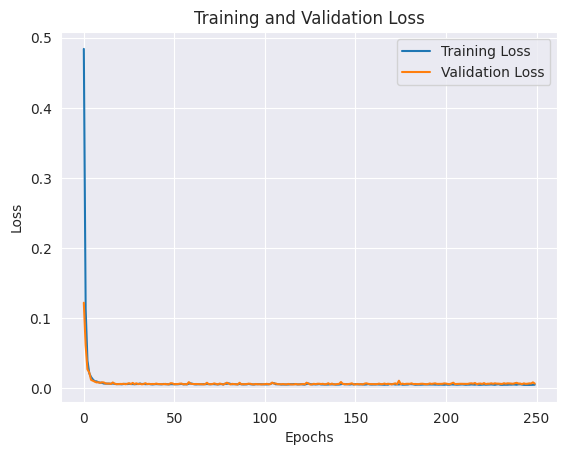

In [63]:
history = compile_and_fit(AMZN_RET_8_ES_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
AMZN_RET_8_ES_predictions = AMZN_RET_8_ES_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_8_ES, AMZN_smape_8_ES = AMZN_RET_8_ES_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0042 - smape: 10.2814


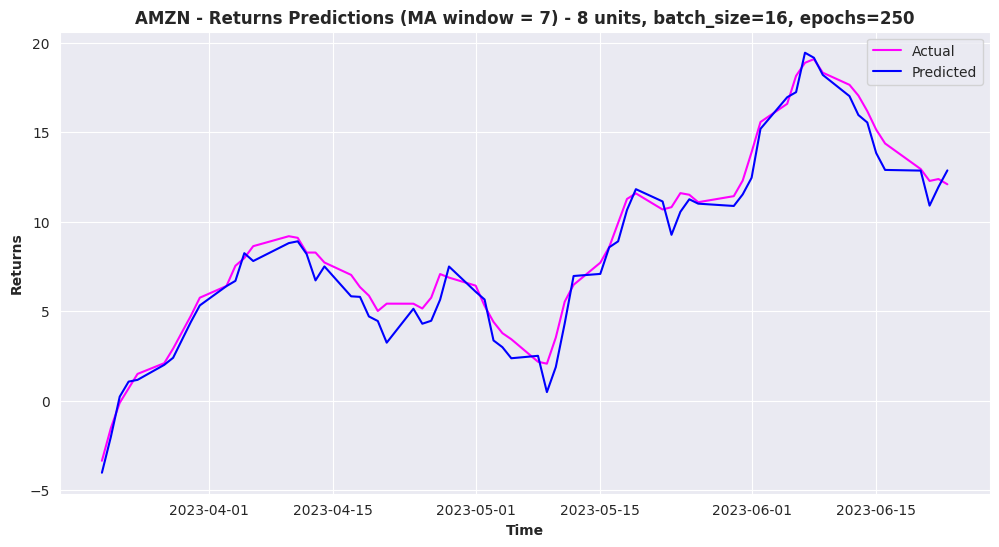

In [65]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_8_ES_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 8 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 16 units, `epochs`=250, `batch_size`=16**

In [66]:
batch_size = 16

############### AAPL - RET_MA #############
AAPL_RET_16_ES_regressor = Sequential()

AAPL_RET_16_ES_regressor.add(LSTM(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_16_ES_regressor.add(Dense(units=1))
##########################################

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (16, 16)                  1152      
                                                                 
 dense_12 (Dense)            (16, 1)                   17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 4s 38ms/step - loss: 0.2431 - smape: 73.0642 - val_loss: 0.1271 - val_smape: 66.5636
Epoch 2/250
32/32 [==============================] - 0s 12ms/step - loss: 0.0579 - smape: 40.8371 - val_loss: 0.0342 - val_smape: 43.9202
Epoch 3/250
32/32 [==============================] - 0s 11ms/step - loss: 0.0227 - smape: 31.4453 - val_loss: 0.0233 - val_smape: 38.0349
Epoch 4/250
32/32 [==============

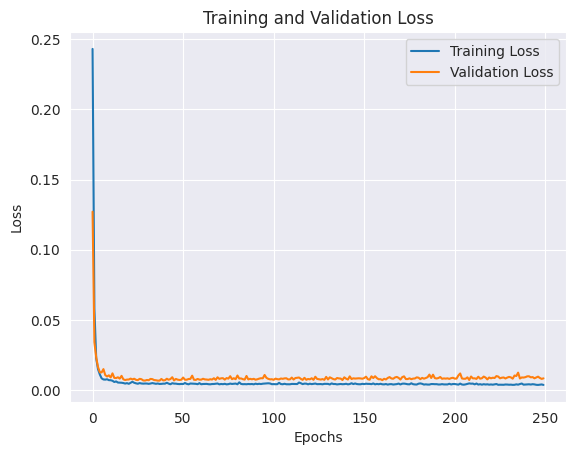

In [67]:
history = compile_and_fit(AAPL_RET_16_ES_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
AAPL_RET_16_ES_predictions = AAPL_RET_16_ES_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_16_ES, AAPL_smape_16_ES = AAPL_RET_16_ES_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0025 - smape: 6.9509


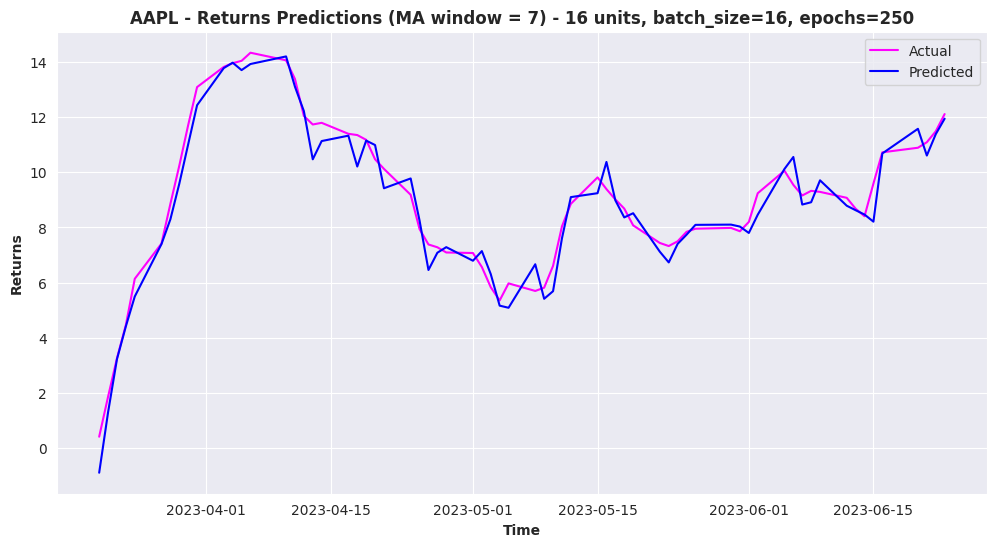

In [69]:
# Inverse transform AAPL Returns
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_16_ES_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 16 units, `epochs`=250, `batch_size`=16**

In [70]:
batch_size = 16

############### AMZN - RET_MA ###############
AMZN_RET_16_ES_regressor = Sequential()

AMZN_RET_16_ES_regressor.add(LSTM(units=16,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_16_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (16, 16)                  1152      
                                                                 
 dense_13 (Dense)            (16, 1)                   17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 4s 38ms/step - loss: 0.2200 - smape: 72.1284 - val_loss: 0.0897 - val_smape: 55.7690
Epoch 2/250
32/32 [==============================] - 0s 9ms/step - loss: 0.0496 - smape: 40.6602 - val_loss: 0.0317 - val_smape: 33.9565
Epoch 3/250
32/32 [==============================] - 0s 7ms/step - loss: 0.0198 - smape: 30.0129 - val_loss: 0.0205 - val_smape: 30.8848
Epoch 4/250
32/32 [================

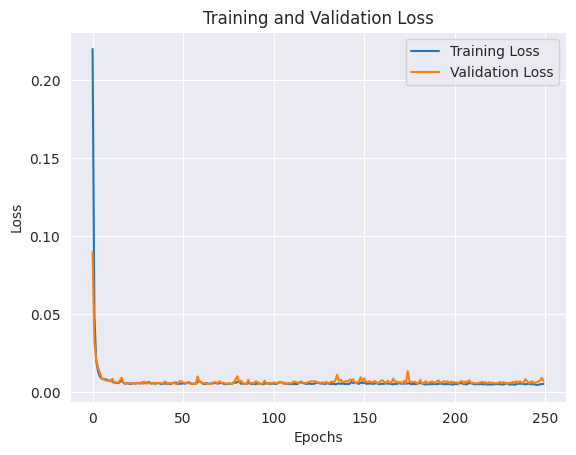

In [71]:
history = compile_and_fit(AMZN_RET_16_ES_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
AMZN_RET_16_ES_predictions = AMZN_RET_16_ES_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_16_ES, AMZN_smape_16_ES = AMZN_RET_16_ES_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0043 - smape: 10.7660


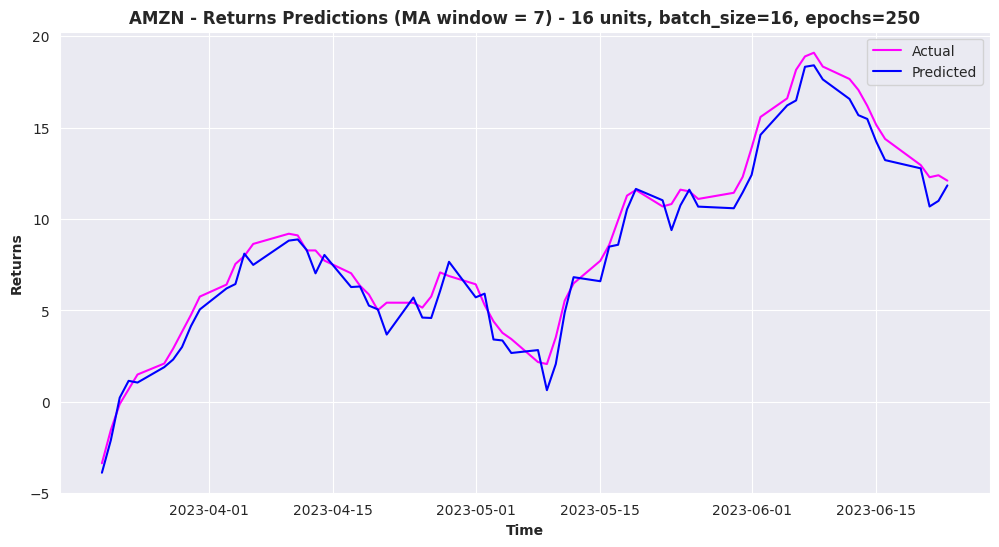

In [73]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_16_ES_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 16 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 32 units, `epochs`=250, `batch_size`=16**

In [74]:
batch_size = 16

############### AAPL - RET_MA ###############
AAPL_RET_32_ES_regressor = Sequential()

AAPL_RET_32_ES_regressor.add(LSTM(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AAPL_RET_32_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (16, 32)                  4352      
                                                                 
 dense_14 (Dense)            (16, 1)                   33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 5s 26ms/step - loss: 0.2728 - smape: 73.0823 - val_loss: 0.0828 - val_smape: 59.2455
Epoch 2/250
32/32 [==============================] - 0s 7ms/step - loss: 0.0416 - smape: 38.4744 - val_loss: 0.0308 - val_smape: 42.8267
Epoch 3/250
32/32 [==============================] - 0s 8ms/step - loss: 0.0227 - smape: 32.3419 - val_loss: 0.0221 - val_smape: 37.0989
Epoch 4/250
32/32 [================

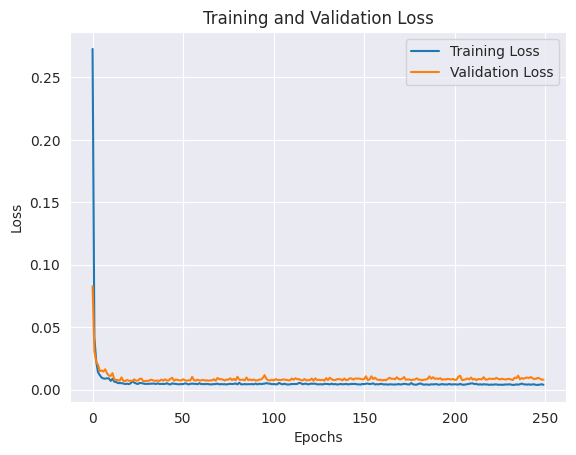

In [75]:
history = compile_and_fit(AAPL_RET_32_ES_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [76]:
AAPL_RET_32_ES_predictions = AAPL_RET_32_ES_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_32_ES, AAPL_smape_32_ES = AAPL_RET_32_ES_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 5ms/step - loss: 0.0027 - smape: 8.2166


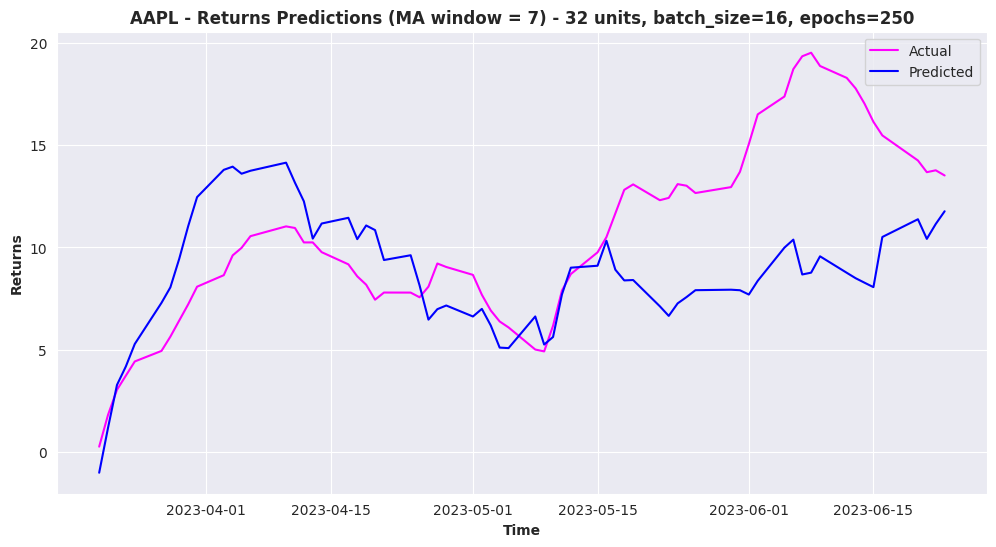

In [77]:
# Inverse transform AAPL Returns
AAPL_test = (AMZN_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_32_ES_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 32 units, `epochs`=250, `batch_size`=16**

In [78]:
batch_size = 16

############### AMZN - RET_MA ###############
AMZN_RET_32_ES_regressor = Sequential()

AMZN_RET_32_ES_regressor.add(LSTM(units=32,
                            batch_input_shape=(batch_size, 7, 1)))

AMZN_RET_32_ES_regressor.add(Dense(units=1))
#############################################

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (16, 32)                  4352      
                                                                 
 dense_15 (Dense)            (16, 1)                   33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
32/32 [==============================] - 3s 27ms/step - loss: 0.2600 - smape: 75.4392 - val_loss: 0.0915 - val_smape: 53.2732
Epoch 2/250
32/32 [==============================] - 0s 8ms/step - loss: 0.0482 - smape: 42.9051 - val_loss: 0.0497 - val_smape: 37.6200
Epoch 3/250
32/32 [==============================] - 0s 7ms/step - loss: 0.0235 - smape: 32.3009 - val_loss: 0.0168 - val_smape: 28.9859
Epoch 4/250
32/32 [================

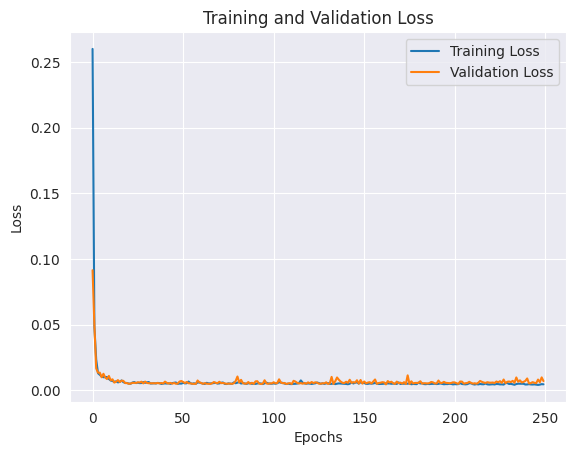

In [79]:
history = compile_and_fit(AMZN_RET_32_ES_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=16)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
AMZN_RET_32_ES_predictions = AMZN_RET_32_ES_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_32_ES, AMZN_smape_32_ES = AMZN_RET_32_ES_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 6ms/step - loss: 0.0039 - smape: 9.6455


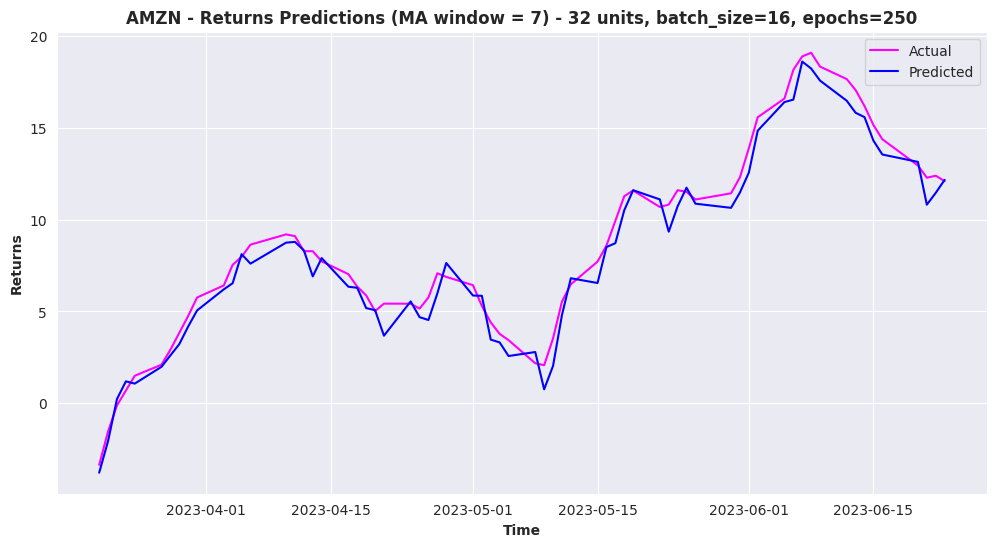

In [81]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_32_ES_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 32 units, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

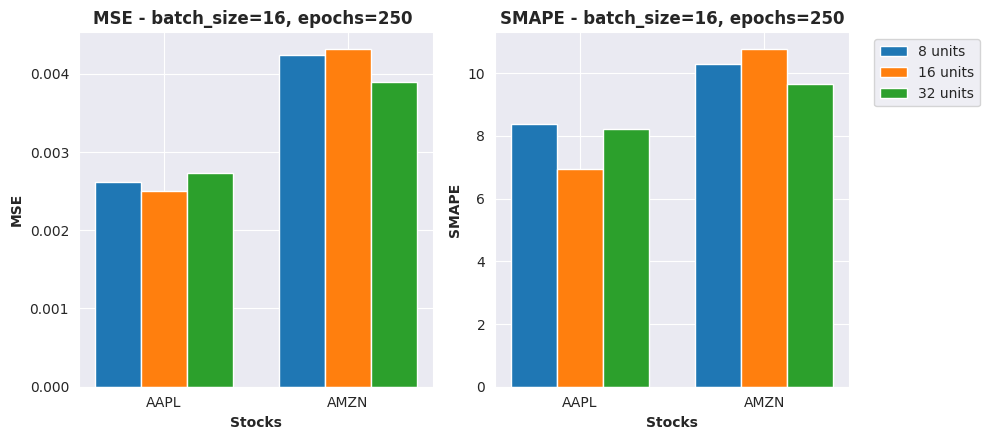

In [82]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_8_ES, AAPL_loss_16_ES, AAPL_loss_32_ES],     [AMZN_loss_8_ES, AMZN_loss_16_ES, AMZN_loss_32_ES]])
smape_values  = np.array([[AAPL_smape_8_ES, AAPL_smape_16_ES, AAPL_smape_32_ES], [AMZN_smape_8_ES, AMZN_smape_16_ES, AMZN_smape_32_ES]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.25, align='center', label='8 units')
axs[0].bar(x + 0.25, loss_values[:, 1], width=0.25, align='center', label='16 units')
axs[0].bar(x + 0.5, loss_values[:, 2], width=0.25, align='center', label='32 units')
axs[0].set_xticks(x + 0.25, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE - batch_size=16, epochs=250 ', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.25, align='center', label='8 units')
axs[1].bar(x + 0.25, smape_values[:, 1], width=0.25, align='center', label='16 units')
axs[1].bar(x + 0.5, smape_values[:, 2], width=0.25, align='center', label='32 units')
axs[1].set_xticks(x + 0.25, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE - batch_size=16, epochs=250', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## **Adding stacked LSTM layers**

### **AAPL - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32**

In [83]:
batch_size = 32

############### AAPL - RET_MA ###############
AAPL_RET_64_2L_regressor = Sequential()

AAPL_RET_64_2L_regressor.add(LSTM(units=64,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AAPL_RET_64_2L_regressor.add(LSTM(units=64))

AAPL_RET_64_2L_regressor.add(Dense(units=1))
#############################################

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (32, 7, 64)               16896     
                                                                 
 lstm_17 (LSTM)              (32, 64)                  33024     
                                                                 
 dense_16 (Dense)            (32, 1)                   65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 6s 125ms/step - loss: 0.2422 - smape: 75.0742 - val_loss: 0.1298 - val_smape: 63.2483
Epoch 2/250
16/16 [==============================] - 0s 26ms/step - loss: 0.0603 - smape: 43.1791 - val_loss: 0.0560 - val_smape: 47.7625
Epoch 3/250
16/16 [=================

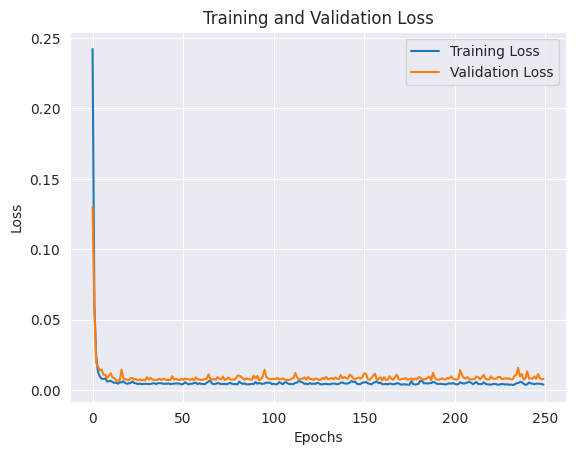

In [84]:
history = compile_and_fit(AAPL_RET_64_2L_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
AAPL_RET_64_2L_predictions = AAPL_RET_64_2L_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_64_2L, AAPL_smape_64_2L = AAPL_RET_64_2L_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0026 - smape: 7.7444


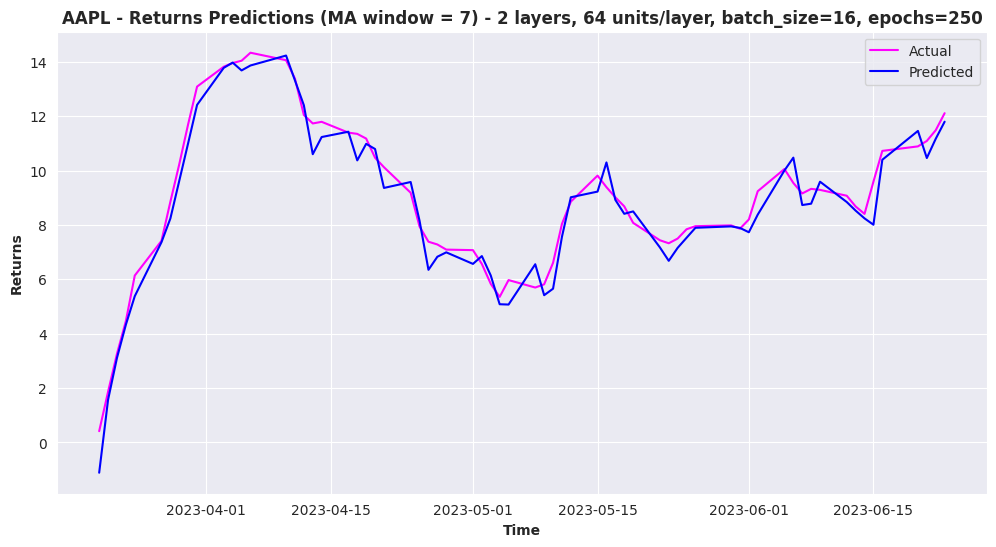

In [86]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_64_2L_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 64 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32**

In [87]:
batch_size = 32

############### AMZN - RET_MA ###############
AMZN_RET_64_2L_regressor = Sequential()

AMZN_RET_64_2L_regressor.add(LSTM(units=64,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AMZN_RET_64_2L_regressor.add(LSTM(units=64))

AMZN_RET_64_2L_regressor.add(Dense(units=1))
#############################################

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (32, 7, 64)               16896     
                                                                 
 lstm_19 (LSTM)              (32, 64)                  33024     
                                                                 
 dense_17 (Dense)            (32, 1)                   65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 5s 82ms/step - loss: 0.2773 - smape: 86.9039 - val_loss: 0.2557 - val_smape: 88.1998
Epoch 2/250
16/16 [==============================] - 0s 18ms/step - loss: 0.1032 - smape: 49.2776 - val_loss: 0.1119 - val_smape: 42.5552
Epoch 3/250
16/16 [==================

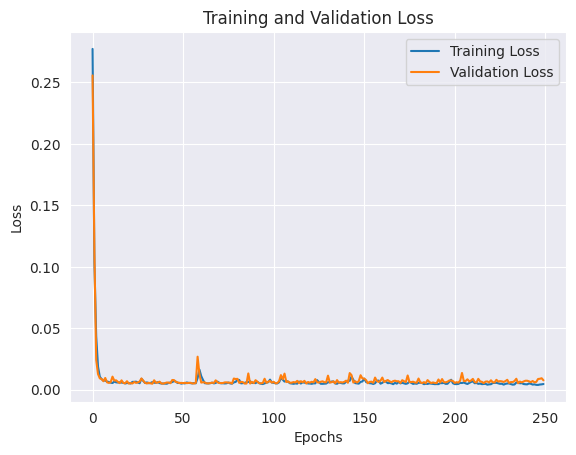

In [88]:
history = compile_and_fit(AMZN_RET_64_2L_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
AMZN_RET_64_2L_predictions = AMZN_RET_64_2L_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_64_2L, AMZN_smape_64_2L = AMZN_RET_64_2L_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0068 - smape: 12.5402


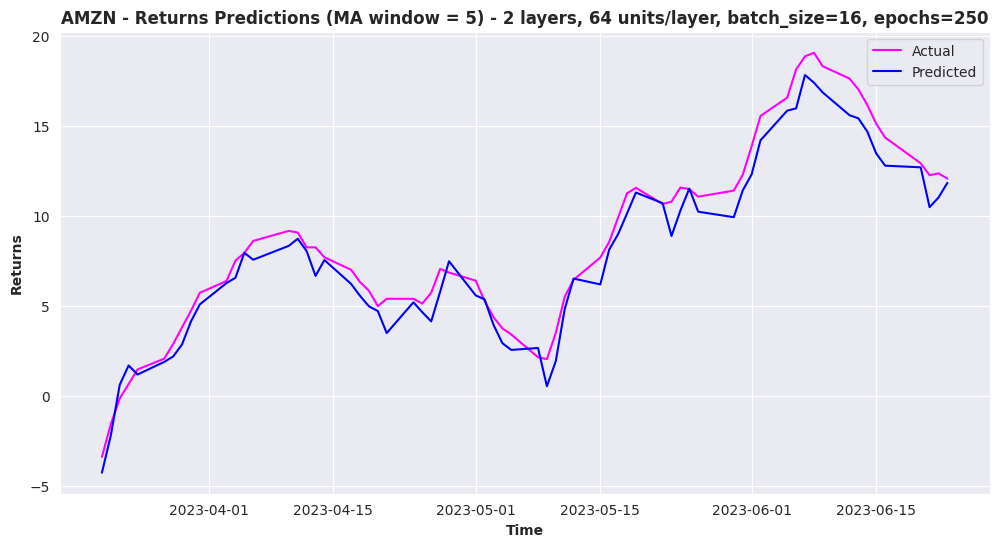

In [90]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_64_2L_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = 5) - 2 layers, 64 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32**

In [91]:
batch_size = 32


AAPL_RET_128_2L_regressor = Sequential()

AAPL_RET_128_2L_regressor.add(LSTM(units=128,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AAPL_RET_128_2L_regressor.add(LSTM(units=128))

AAPL_RET_128_2L_regressor.add(Dense(units=1))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (32, 7, 128)              66560     
                                                                 
 lstm_21 (LSTM)              (32, 128)                 131584    
                                                                 
 dense_18 (Dense)            (32, 1)                   129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 10s 294ms/step - loss: 0.3497 - smape: 87.4879 - val_loss: 0.2028 - val_smape: 73.3009
Epoch 2/250
16/16 [==============================] - 1s 60ms/step - loss: 0.1497 - smape: 59.6103 - val_loss: 0.0578 - val_smape: 51.0488
Epoch 3/250
16/16 [==============

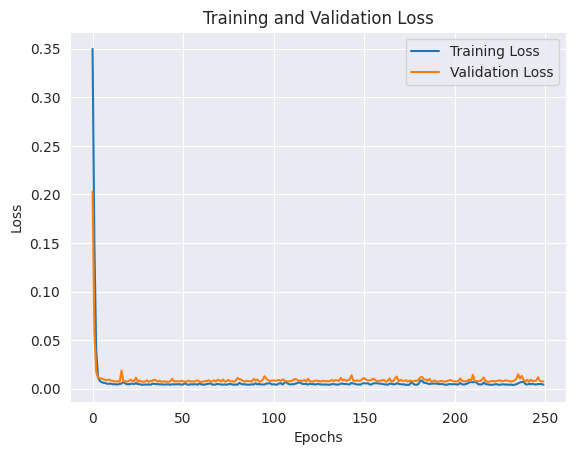

In [92]:
history = compile_and_fit(AAPL_RET_128_2L_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
AAPL_RET_128_2L_predictions = AAPL_RET_128_2L_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_128_2L, AAPL_smape_128_2L = AAPL_RET_128_2L_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 12ms/step - loss: 0.0024 - smape: 7.5088


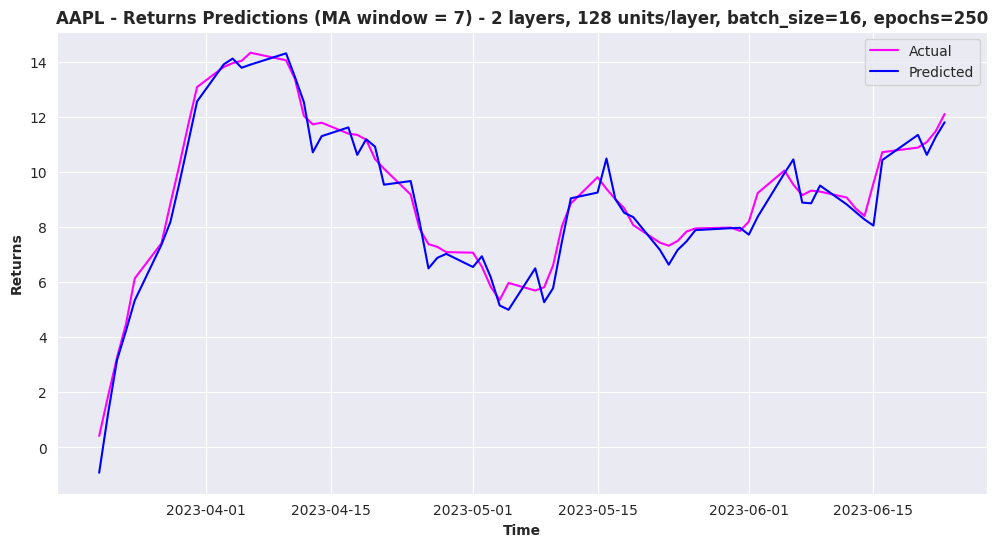

In [94]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_128_2L_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32**

In [95]:
batch_size = 32

############### AMZN - RET_MA ###############
AMZN_RET_128_2L_regressor = Sequential()

AMZN_RET_128_2L_regressor.add(LSTM(units=128,
                            batch_input_shape=(batch_size, 7, 1),
                            return_sequences=True))

AMZN_RET_128_2L_regressor.add(LSTM(units=128))

AMZN_RET_128_2L_regressor.add(Dense(units=1))
#############################################

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (32, 7, 128)              66560     
                                                                 
 lstm_23 (LSTM)              (32, 128)                 131584    
                                                                 
 dense_19 (Dense)            (32, 1)                   129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 5s 97ms/step - loss: 0.6100 - smape: 108.3035 - val_loss: 0.4262 - val_smape: 110.6523
Epoch 2/250
16/16 [==============================] - 1s 34ms/step - loss: 0.2755 - smape: 81.7416 - val_loss: 0.1456 - val_smape: 69.8132
Epoch 3/250
16/16 [==============

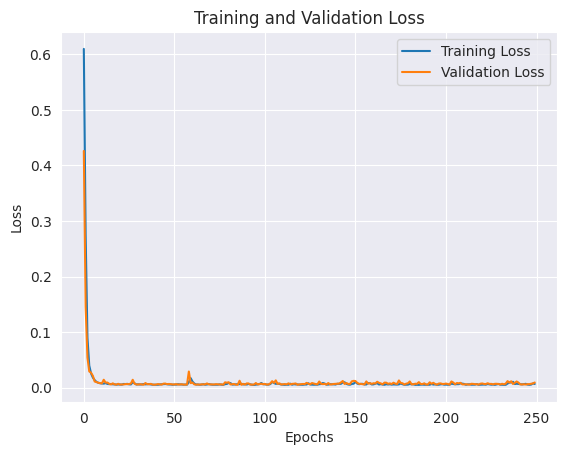

In [96]:
history = compile_and_fit(AMZN_RET_128_2L_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
AMZN_RET_128_2L_predictions = AMZN_RET_128_2L_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_128_2L, AMZN_smape_128_2L = AMZN_RET_128_2L_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 14ms/step - loss: 0.0067 - smape: 11.7344


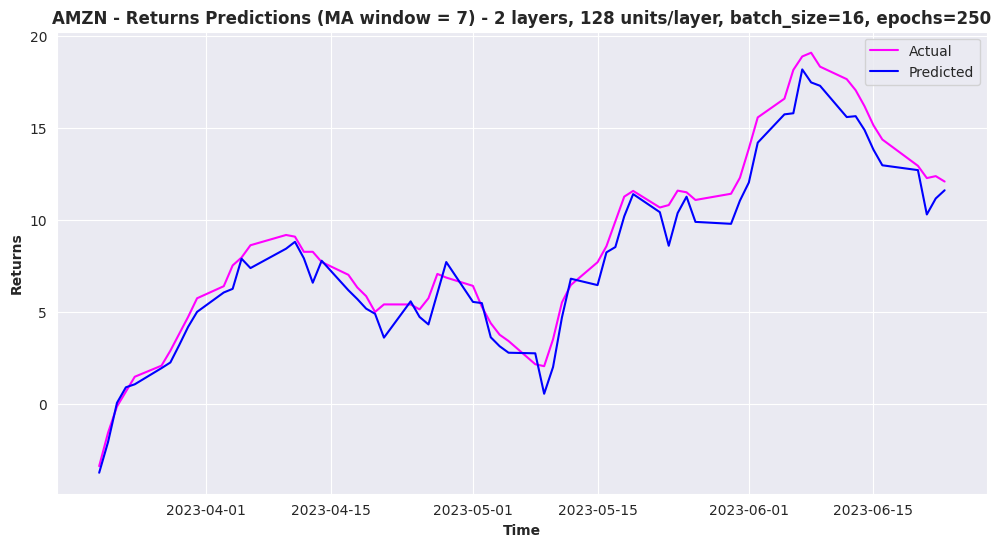

In [98]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_128_2L_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

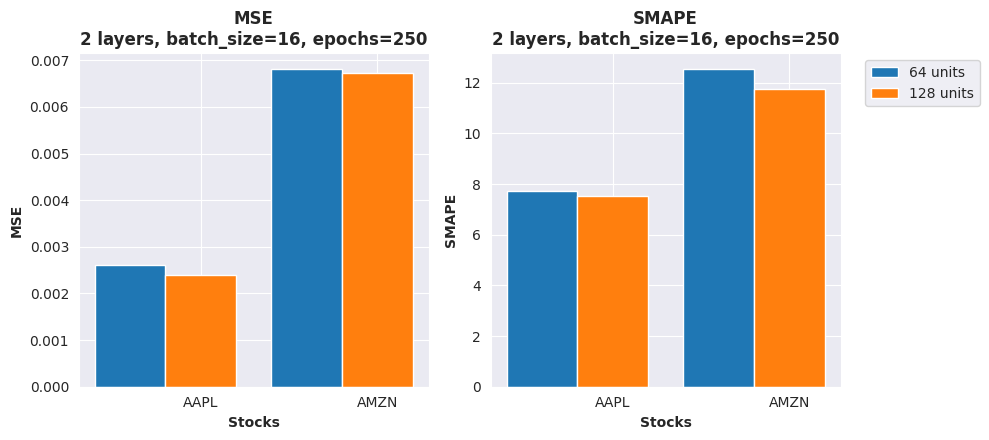

In [113]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_64_2L, AAPL_loss_128_2L],     [AMZN_loss_64_2L, AMZN_loss_128_2L]])
smape_values  = np.array([[AAPL_smape_64_2L, AAPL_smape_128_2L], [AMZN_smape_64_2L, AMZN_smape_128_2L]])

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.4, align='center', label='64 units')
axs[0].bar(x + 0.4, loss_values[:, 1], width=0.4, align='center', label='128 units')
axs[0].set_xticks(x + 0.4, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.4, align='center', label='64 units')
axs[1].bar(x + 0.4, smape_values[:, 1], width=0.4, align='center', label='128 units')
axs[1].set_xticks(x + 0.4, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

It seems like we should remove complexity instead of adding it...

# **Adding dropout**

### **AAPL - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [155]:
batch_size = 32

############### AMZN - RET_MA ###############
AAPL_RET_64_2L_D_regressor = Sequential()

AAPL_RET_64_2L_D_regressor.add(LSTM(units=64,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AAPL_RET_64_2L_D_regressor.add(LSTM(units=64,
                                  dropout=0.2))

AAPL_RET_64_2L_D_regressor.add(Dense(units=1))
#############################################

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (32, 7, 64)               16896     
                                                                 
 lstm_93 (LSTM)              (32, 64)                  33024     
                                                                 
 dense_78 (Dense)            (32, 1)                   65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 6s 96ms/step - loss: 0.2818 - smape: 79.3243 - val_loss: 0.1544 - val_smape: 69.4086
Epoch 2/250
16/16 [==============================] - 0s 28ms/step - loss: 0.1677 - smape: 61.8503 - val_loss: 0.0939 - val_smape: 61.9136
Epoch 3/250
16/16 [==================

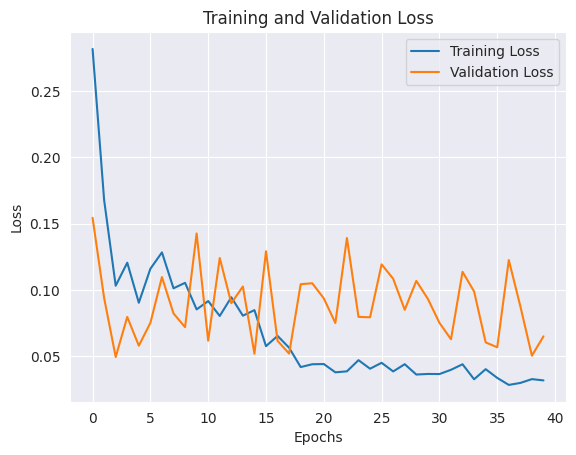

In [156]:
history = compile_and_fit(AAPL_RET_64_2L_D_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [157]:
AAPL_RET_64_2L_D_predictions = AAPL_RET_64_2L_D_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_64_2L_D, AAPL_smape_64_2L_D = AAPL_RET_64_2L_D_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0200 - smape: 26.1785


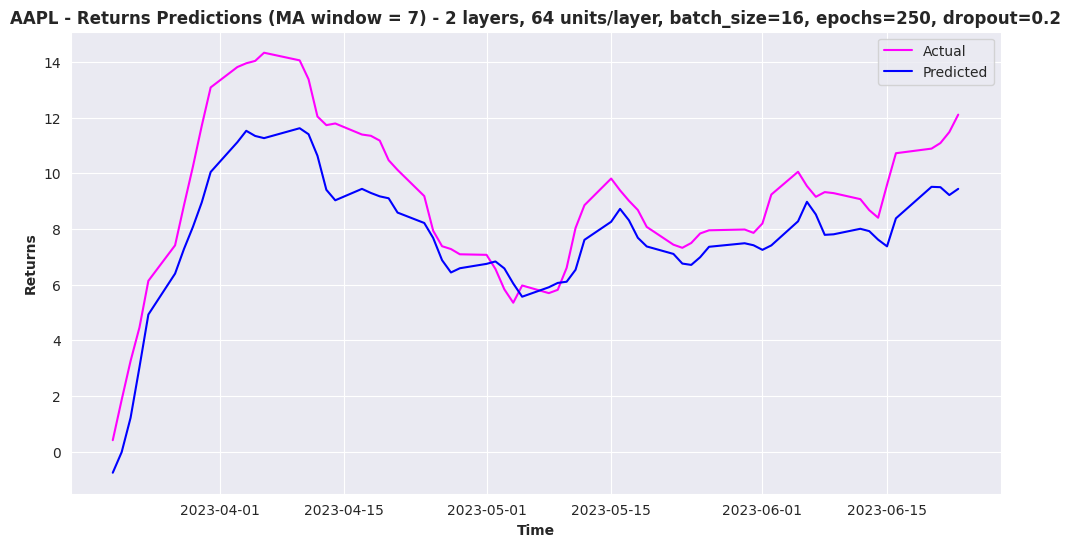

In [158]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_64_2L_D_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 64 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 64 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [159]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_64_2L_D_regressor = Sequential()

AMZN_RET_64_2L_D_regressor.add(LSTM(units=64,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AMZN_RET_64_2L_D_regressor.add(LSTM(units=64,
                                  dropout=0.2))

AMZN_RET_64_2L_D_regressor.add(Dense(units=1))
################################################

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_94 (LSTM)              (32, 7, 64)               16896     
                                                                 
 lstm_95 (LSTM)              (32, 64)                  33024     
                                                                 
 dense_79 (Dense)            (32, 1)                   65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 7s 178ms/step - loss: 0.3216 - smape: 90.5590 - val_loss: 0.1541 - val_smape: 65.2970
Epoch 2/250
16/16 [==============================] - 0s 28ms/step - loss: 0.2103 - smape: 71.9600 - val_loss: 0.0718 - val_smape: 59.6076
Epoch 3/250
16/16 [=================

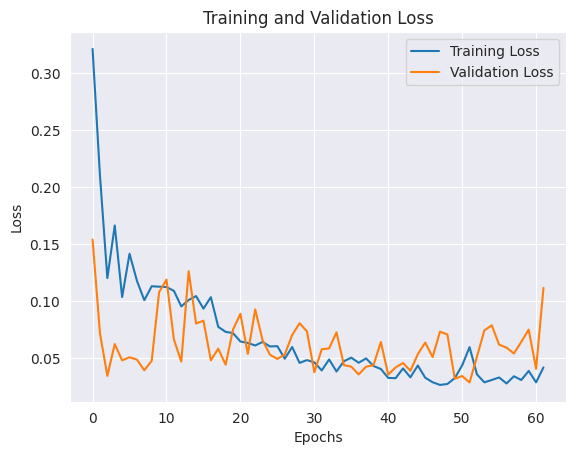

In [160]:
history = compile_and_fit(AMZN_RET_64_2L_D_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [161]:
AMZN_RET_64_2L_D_predictions = AMZN_RET_64_2L_D_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_64_2L_D, AMZN_smape_64_2L_D = AMZN_RET_64_2L_D_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 7ms/step - loss: 0.0341 - smape: 27.2862


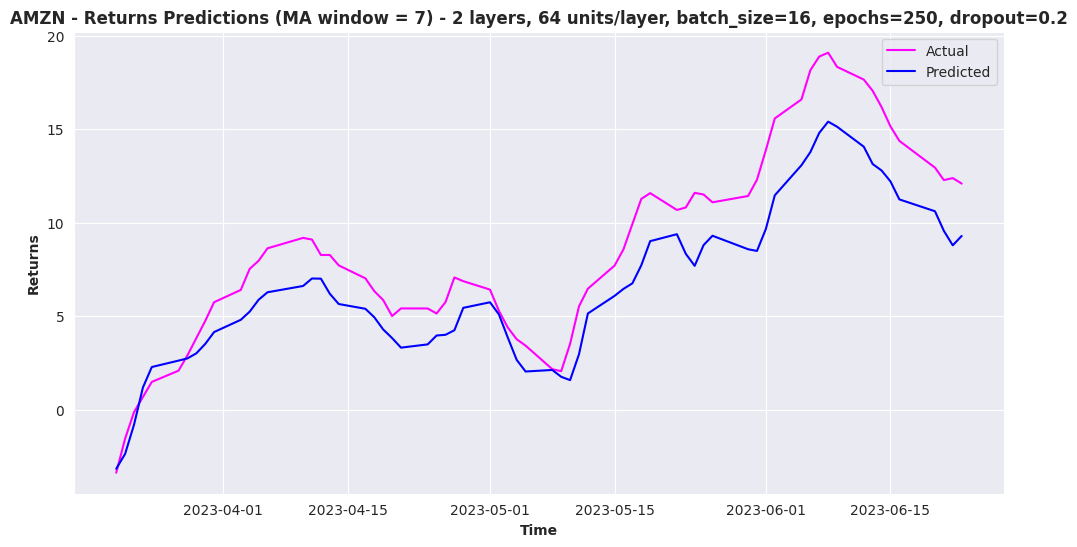

In [162]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_64_2L_D_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 64 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AAPL - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [163]:
batch_size = 32

############### AMZN - RET_MA ###############
AAPL_RET_128_2L_D_regressor = Sequential()

AAPL_RET_128_2L_D_regressor.add(LSTM(units=128,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AAPL_RET_128_2L_D_regressor.add(LSTM(units=128,
                                  dropout=0.2))

AAPL_RET_128_2L_D_regressor.add(Dense(units=1))
#############################################

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (32, 7, 128)              66560     
                                                                 
 lstm_97 (LSTM)              (32, 128)                 131584    
                                                                 
 dense_80 (Dense)            (32, 1)                   129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 6s 96ms/step - loss: 0.5349 - smape: 93.5113 - val_loss: 0.2707 - val_smape: 84.1161
Epoch 2/250
16/16 [==============================] - 1s 34ms/step - loss: 0.2995 - smape: 85.1606 - val_loss: 0.2739 - val_smape: 87.4472
Epoch 3/250
16/16 [================

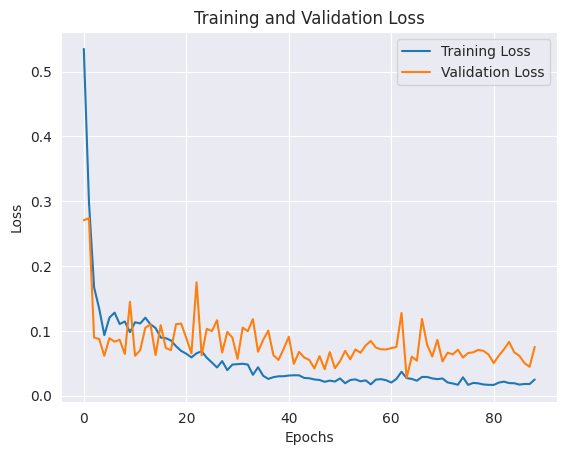

In [164]:
history = compile_and_fit(AAPL_RET_128_2L_D_regressor,
                          X_train=AAPL_RET_MA_X_train,
                          Y_train=AAPL_RET_MA_Y_train,
                          X_val=AAPL_RET_MA_X_val,
                          Y_val=AAPL_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [165]:
AAPL_RET_128_2L_D_predictions = AAPL_RET_128_2L_D_regressor.predict(AAPL_RET_MA_X_test)
AAPL_loss_128_2L_D, AAPL_smape_128_2L_D = AAPL_RET_128_2L_D_regressor.evaluate(AAPL_RET_MA_X_test, AAPL_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 11ms/step - loss: 0.0365 - smape: 39.3488


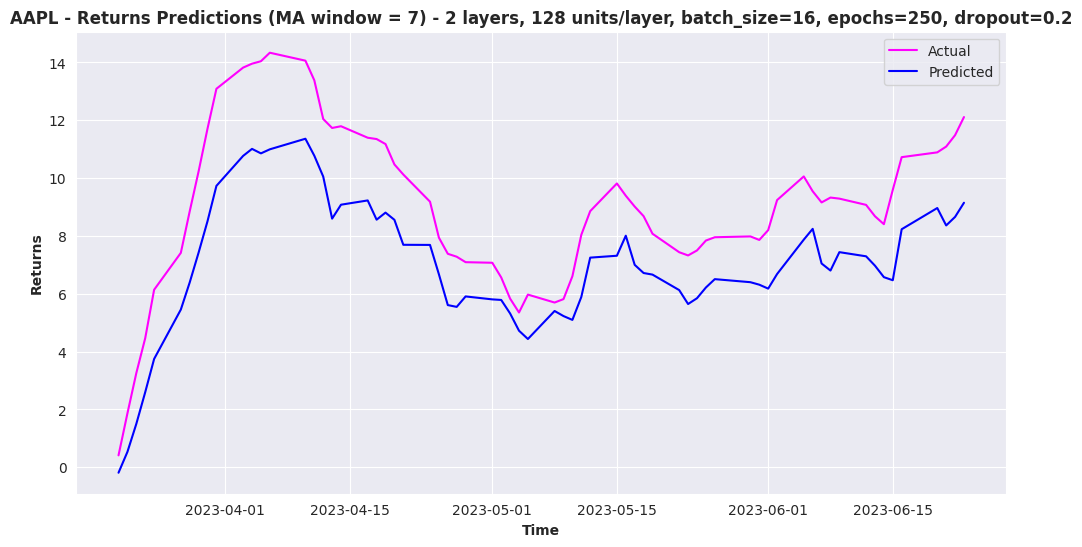

In [166]:
AAPL_test = (AAPL_RET_MA_Y_test * AAPL_std_MA) + AAPL_mean_MA
AAPL_predictions = (AAPL_RET_128_2L_D_predictions * AAPL_std_MA) + AAPL_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_test, label='Actual', color='magenta')
plt.plot(AAPL_reduced.index[-len(AAPL_RET_MA_Y_test):].values, AAPL_predictions, label='Predicted', color='blue')
plt.title('AAPL - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

### **AMZN - 2 layers, 128 units per layer, `epochs`=250, `batch_size`=32, `dropout`=0.2**

In [167]:
batch_size = 32

############### AMZN - LOGRET_MA ###############
AMZN_RET_128_2L_D_regressor = Sequential()

AMZN_RET_128_2L_D_regressor.add(LSTM(units=128,
                                  dropout=0.2,
                                  batch_input_shape=(batch_size, 7, 1),
                                  return_sequences=True))

AMZN_RET_128_2L_D_regressor.add(LSTM(units=128,
                                  dropout=0.2))

AMZN_RET_128_2L_D_regressor.add(Dense(units=1))
################################################

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_98 (LSTM)              (32, 7, 128)              66560     
                                                                 
 lstm_99 (LSTM)              (32, 128)                 131584    
                                                                 
 dense_81 (Dense)            (32, 1)                   129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
16/16 [==============================] - 6s 113ms/step - loss: 0.7248 - smape: 108.8286 - val_loss: 0.3063 - val_smape: 95.3545
Epoch 2/250
16/16 [==============================] - 1s 54ms/step - loss: 0.3322 - smape: 89.6181 - val_loss: 0.2892 - val_smape: 80.7717
Epoch 3/250
16/16 [==============

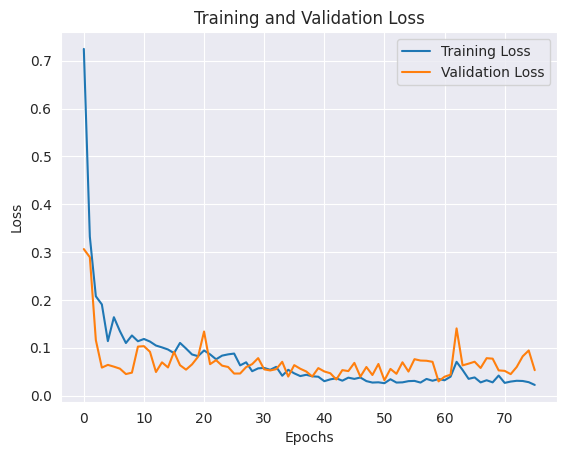

In [168]:
history = compile_and_fit(AMZN_RET_128_2L_D_regressor,
                          X_train=AMZN_RET_MA_X_train,
                          Y_train=AMZN_RET_MA_Y_train,
                          X_val=AMZN_RET_MA_X_val,
                          Y_val=AMZN_RET_MA_Y_val,
                          _epochs=250,
                          _batch_size=32,
                          _early_stopping=True,
                          _patience=25)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [169]:
AMZN_RET_128_2L_D_predictions = AMZN_RET_128_2L_D_regressor.predict(AMZN_RET_MA_X_test)
AMZN_loss_128_2L_D, AMZN_smape_128_2L_D = AMZN_RET_128_2L_D_regressor.evaluate(AMZN_RET_MA_X_test, AMZN_RET_MA_Y_test, batch_size=32)

3/3 [==============================] - 0s 9ms/step - loss: 0.0325 - smape: 26.3130


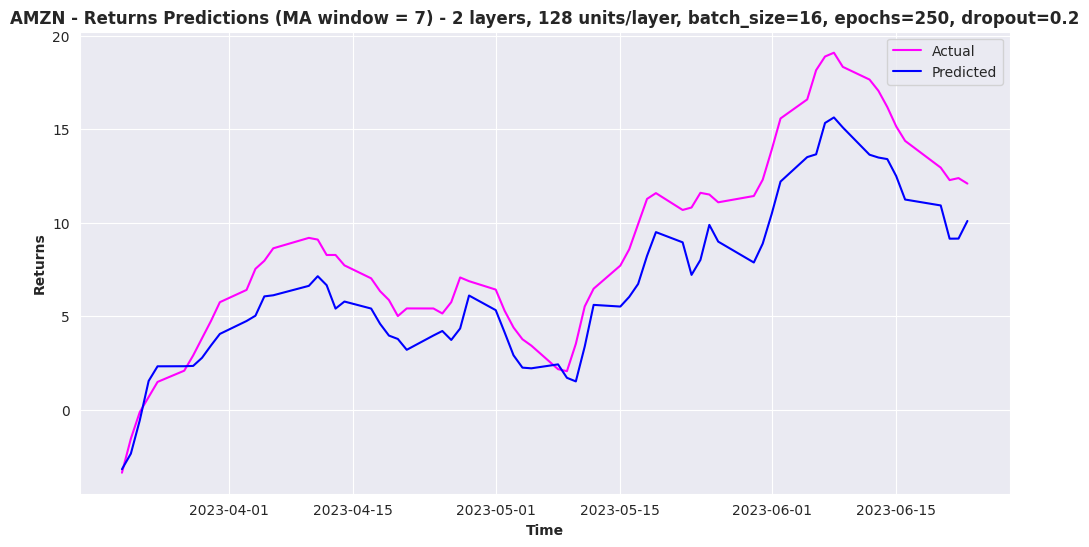

In [170]:
AMZN_test = (AMZN_RET_MA_Y_test * AMZN_std_MA) + AMZN_mean_MA
AMZN_predictions = (AMZN_RET_128_2L_D_predictions * AMZN_std_MA) + AMZN_mean_MA

plt.figure(figsize=(12, 6))
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_test, label='Actual', color='magenta')
plt.plot(AMZN_reduced.index[-len(AMZN_RET_MA_Y_test):].values, AMZN_predictions, label='Predicted', color='blue')
plt.title('AMZN - Returns Predictions (MA window = ' + str(window_size) + ') - 2 layers, 128 units/layer, batch_size=16, epochs=250, dropout=0.2', fontweight='bold')
plt.xlabel('Time', fontweight='bold')
plt.ylabel('Returns', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

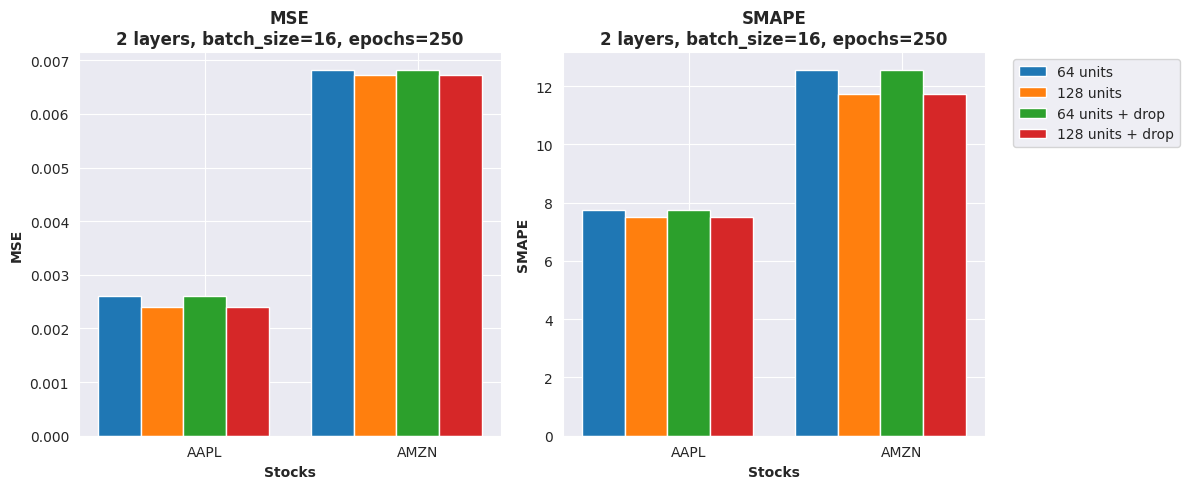

In [171]:
labels = ['AAPL', 'AMZN']
x = np.arange(len(labels))

loss_values = np.array([[AAPL_loss_64_2L, AAPL_loss_128_2L, AAPL_loss_64_2L_D, AAPL_loss_128_2L_D],       [AMZN_loss_64_2L, AMZN_loss_128_2L, AMZN_loss_64_2L_D, AMZN_loss_128_2L_D]])
smape_values  = np.array([[AAPL_smape_64_2L, AAPL_smape_128_2L, AAPL_smape_64_2L_D, AAPL_smape_128_2L_D], [AMZN_smape_64_2L, AMZN_smape_128_2L, AMZN_smape_64_2L_D, AMZN_smape_128_2L_D]])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the loss bar chart
axs[0].bar(x, loss_values[:, 0], width=0.2, align='center', label='64 units')
axs[0].bar(x + 0.2, loss_values[:, 1], width=0.2, align='center', label='128 units')
axs[0].bar(x + 0.4, loss_values[:, 0], width=0.2, align='center', label='64 units + drop')
axs[0].bar(x + 0.6, loss_values[:, 1], width=0.2, align='center', label='128 units + drop')
axs[0].set_xticks(x + 0.4, labels)
axs[0].set_xlabel('Stocks', fontweight='bold')
axs[0].set_ylabel('MSE', fontweight='bold')
axs[0].set_title('MSE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Plotting the smape bar chart
axs[1].bar(x, smape_values[:, 0], width=0.2, align='center', label='64 units')
axs[1].bar(x + 0.2, smape_values[:, 1], width=0.2, align='center', label='128 units')
axs[1].bar(x + 0.4, smape_values[:, 0], width=0.2, align='center', label='64 units + drop')
axs[1].bar(x + 0.6, smape_values[:, 1], width=0.2, align='center', label='128 units + drop')
axs[1].set_xticks(x + 0.4, labels)
axs[1].set_xlabel('Stocks', fontweight='bold')
axs[1].set_ylabel('SMAPE', fontweight='bold')
axs[1].set_title('SMAPE\n2 layers, batch_size=16, epochs=250', fontweight='bold')

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()